In [2]:
'''
This file is for examining results relating to species richness and abundance,
including richness, shannon, pielou indices,
simper analysis
friedman tests between sorting process for each individual taxa
and bar graphs to show various results
BE SURE TO CHECK WHICH .xlsx file is being imported...5000 vs Max vs others?
'''


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.stats import wilcoxon

In [3]:
# FUNCTIONS
def simper(data, groups, metric='braycurtis', top_n=10):
    """
    Perform SIMPER analysis.
    
    Parameters:
        data (pd.DataFrame): Rows are samples, columns are species abundances.
        groups (list or pd.Series): Grouping variable for the samples.
        metric (str): Distance metric (e.g., 'braycurtis', 'euclidean').
        top_n (int): Number of top contributors to return.
    
    Returns:
        pd.DataFrame: Species contributions to group dissimilarities.
    """
    # Compute the dissimilarity matrix
    # print("type of data: ")
    data = data.loc[:, (data != 0).any(axis=0)]
    # print("data: ", data)
    dist_matrix = squareform(pdist(data, metric=metric))
    # print("dist_matrix:", dist_matrix)
    # print(dist_matrix)
    # Get unique groups
    unique_groups = np.unique(groups)
    results = []

    # Compare each pair of groups
    for i in range(len(unique_groups)):
        for j in range(i + 1, len(unique_groups)):
            group1 = unique_groups[i]
            group2 = unique_groups[j]
            
            # Subset samples for the two groups
            idx1 = np.where(groups == group1)[0]
            idx2 = np.where(groups == group2)[0]
            
            # Compute average dissimilarity between groups
            # print(idx1, idx2)
            dissimilarities = dist_matrix[np.ix_(idx1, idx2)].mean()
            # print(f"mean dissim for {unique_groups[i]} and {unique_groups[j]} ", dissimilarities)
            # Compute average abundances for each group
            avg_abundance1 = data.iloc[idx1].mean(axis=0)
            avg_abundance2 = data.iloc[idx2].mean(axis=0)
            
            # Calculate species contributions
            contributions = abs(avg_abundance1 - avg_abundance2) * (avg_abundance1 + avg_abundance2)
            contributions = contributions / contributions.sum() * 100  # Normalize to percentage
            
            # Rank species by contributions
            # ranked = contributions.sort_values(ascending=False).head(top_n)
            ranked = contributions
            
            # Store results
            for species, contribution in ranked.items():
                results.append({
                    'Group1': group1,
                    'Group2': group2,
                    'Species': species,
                    'Contribution (%)': contribution,
                    'Cumulative (%)': ranked[:ranked.index.get_loc(species) + 1].sum(),
                    'Dissimilarity (%)' : dissimilarities,
                })

    return pd.DataFrame(results)

def shannon_diversity_index(species_counts):
    """
    Calculate the Shannon Diversity Index (H') for a given list of species counts.
    
    Parameters:
    species_counts (list or array): A list of counts for each species.

    Returns:
    float: The Shannon Diversity Index (H').
    """
    # Convert counts to proportions
    total_count = np.sum(species_counts)
    
    proportions = species_counts / total_count
    # Remove zero proportions to avoid log(0) issues
    proportions = proportions[proportions > 0]

    # Calculate Shannon index
    shannon_index = -np.sum(proportions * np.log(proportions))
    return shannon_index

def pielou_evenness_index(species_counts):
    """
    Calculate Pielou's Evenness Index (J') for a given list of species counts.
    
    Parameters:
    species_counts (list or array): A list of counts for each species.

    Returns:
    float: Pielou's Evenness Index (J').
    """
    # Total number of species (non-zero counts)
    S = np.sum(species_counts > 0)
    
    if S <= 1:
        # Evenness is undefined for 1 or fewer species
        return 0.0
    
    # Calculate Shannon Diversity Index
    H = shannon_diversity_index(species_counts)
    
    # Calculate Pielou's Evenness Index
    J = H / np.log(S)
    return J

In [4]:
#taxa we are excluding due to limitations of a sorting process (like medusa being too large for flowcam)
taxa_exclusion_list = []

In [5]:
#this is where the relative abundances are imported. Be sure to check the file name for desired computer predictions based on training strategy.
# max_relabunds.xlsx is for predictions with the model that has max_traning_class = unlimited
# relabunds.xlsx is for predictions from max_training_class = 5000
max_relabund_df = pd.read_excel('max_strat4_relabunds_feb4.xlsx')
#change names of sorting processes, then sort.
max_relabund_df = max_relabund_df.replace('AI', 'CI')
max_relabund_df = max_relabund_df.replace('MC', 'HM')
max_relabund_df = max_relabund_df.replace('FC', 'HI')
max_relabund_df = max_relabund_df.sort_values(by=['newName', 'regionYear', 'type', 'FlowCamID']).reset_index(drop=True)
#change region names
max_relabund_df = max_relabund_df.replace({'Gulf 2020': 'Gulf', 'Pac 21': 'Pacific' })
#remove rows where the newName matches any taxa in the taxa_exclusion_list
max_relabund_df = max_relabund_df[~max_relabund_df['newName'].isin(taxa_exclusion_list)]
max_relabund_df

,Unnamed: 0,newName,FlowCamID,type,regionYear,abund,sumabund,relabund
0,30,Acartia spp.,AMMP_Gulf_StPeters_1_20200903HT_250UM,CI,Gulf,263.000000,3847.000000,0.068365
1,33,Acartia spp.,AMMP_Gulf_StPeters_1_20200903LT_250UM,CI,Gulf,1571.000000,3268.000000,0.480722
2,36,Acartia spp.,AMMP_Gulf_StPeters_1_20200904HT_250UM,CI,Gulf,267.000000,7495.000000,0.035624
3,39,Acartia spp.,AMMP_Gulf_StPeters_2B_20200903_250UM,CI,Gulf,1910.000000,2895.000000,0.659758
4,42,Acartia spp.,AMMP_Gulf_StPeters_2_20200903HT_250UM,CI,Gulf,1994.000000,4104.000000,0.485867
...,...,...,...,...,...,...,...,...
4225,4217,Tortanus spp.,AMMP_PA_S04W15_20210609LT_250um,HM,Pacific,2.591720,3992.867992,0.000649
4226,4220,Tortanus spp.,AMMP_PA_S04W15_20210610LT_250um,HM,Pacific,20.081536,4835.466496,0.004153
4227,4223,Tortanus spp.,AMMP_PA_S04W20_20210609HT_250um,HM,Pacific,7.060098,2970.977322,0.002376
4228,4226,Tortanus spp.,AMMP_PA_S04W20_20210609LT_250um,HM,Pacific,3.662212,5824.062256,0.000629


In [6]:
#this is where the relative abundances are imported. Be sure to check the file name for desired computer predictions based on training strategy.
# max_relabunds.xlsx is for predictions with the model that has max_traning_class = unlimited
# relabunds.xlsx is for predictions from max_training_class = 5000
relabund_df = pd.read_excel('five_thousand_strat4_relabunds_feb4.xlsx')
#change names of sorting processes, then sort.
relabund_df = relabund_df.replace('AI', 'CI')
relabund_df = relabund_df.replace('MC', 'HM')
relabund_df = relabund_df.replace('FC', 'HI')
relabund_df = relabund_df.sort_values(by=['newName', 'regionYear', 'type', 'FlowCamID']).reset_index(drop=True)
#change region names
relabund_df = relabund_df.replace({'Gulf 2020': 'Gulf', 'Pac 21': 'Pacific' })
#remove rows where the newName matches any taxa in the taxa_exclusion_list
relabund_df = relabund_df[~relabund_df['newName'].isin(taxa_exclusion_list)]
relabund_df

,Unnamed: 0,newName,FlowCamID,type,regionYear,abund,sumabund,relabund
0,30,Acartia spp.,AMMP_Gulf_StPeters_1_20200903HT_250UM,CI,Gulf,52.000000,3847.000000,0.013517
1,33,Acartia spp.,AMMP_Gulf_StPeters_1_20200903LT_250UM,CI,Gulf,927.000000,3268.000000,0.283660
2,36,Acartia spp.,AMMP_Gulf_StPeters_1_20200904HT_250UM,CI,Gulf,99.000000,7495.000000,0.013209
3,39,Acartia spp.,AMMP_Gulf_StPeters_2B_20200903_250UM,CI,Gulf,1127.000000,2895.000000,0.389292
4,42,Acartia spp.,AMMP_Gulf_StPeters_2_20200903HT_250UM,CI,Gulf,1194.000000,4104.000000,0.290936
...,...,...,...,...,...,...,...,...
4255,4247,Tortanus spp.,AMMP_PA_S04W15_20210609LT_250um,HM,Pacific,2.591720,3992.867992,0.000649
4256,4250,Tortanus spp.,AMMP_PA_S04W15_20210610LT_250um,HM,Pacific,20.081536,4835.466496,0.004153
4257,4253,Tortanus spp.,AMMP_PA_S04W20_20210609HT_250um,HM,Pacific,7.060098,2970.977322,0.002376
4258,4256,Tortanus spp.,AMMP_PA_S04W20_20210609LT_250um,HM,Pacific,3.662212,5824.062256,0.000629


In [7]:
# add tortanus with zeroes to max_relabund_df in Gulf region
tort_df = relabund_df[(relabund_df['newName'] == 'Tortanus spp.') & (relabund_df['regionYear'] == 'Gulf')].copy()
tort_df['abund'] = 0
tort_df['relabund'] = 0
max_relabund_df = pd.concat([max_relabund_df, tort_df])
max_relabund_df = max_relabund_df.sort_values(by=['newName', 'regionYear', 'type', 'FlowCamID']).reset_index(drop=True)

In [8]:
#add max gulf to relabund_df
max_gulf = max_relabund_df[max_relabund_df['regionYear'] == 'Gulf'].copy()
max_gulf = max_gulf.replace({'CI': 'CI-u'})
max_gulf = max_gulf[max_gulf['type'] == 'CI-u']
relabund_df = pd.concat([relabund_df, max_gulf])
relabund_df['type'].unique()
relabund_df[relabund_df['type'] == 'CI-u']

,Unnamed: 0,newName,FlowCamID,type,regionYear,abund,sumabund,relabund
0,30,Acartia spp.,AMMP_Gulf_StPeters_1_20200903HT_250UM,CI-u,Gulf,263.0,3847.0,0.068365
1,33,Acartia spp.,AMMP_Gulf_StPeters_1_20200903LT_250UM,CI-u,Gulf,1571.0,3268.0,0.480722
2,36,Acartia spp.,AMMP_Gulf_StPeters_1_20200904HT_250UM,CI-u,Gulf,267.0,7495.0,0.035624
3,39,Acartia spp.,AMMP_Gulf_StPeters_2B_20200903_250UM,CI-u,Gulf,1910.0,2895.0,0.659758
4,42,Acartia spp.,AMMP_Gulf_StPeters_2_20200903HT_250UM,CI-u,Gulf,1994.0,4104.0,0.485867
...,...,...,...,...,...,...,...,...
4175,4215,Tortanus spp.,AMMP_Gulf_StPeters_2_20200904HT_250UM,CI-u,Gulf,0.0,4177.0,0.000000
4176,4218,Tortanus spp.,AMMP_Gulf_StPeters_3B_20200903_250UM,CI-u,Gulf,0.0,3322.0,0.000000
4177,4221,Tortanus spp.,AMMP_Gulf_StPeters_3_20200903HT_250UM,CI-u,Gulf,0.0,3231.0,0.000000
4178,4224,Tortanus spp.,AMMP_Gulf_StPeters_3_20200903LT_250UM,CI-u,Gulf,0.0,3594.0,0.000000


In [9]:
types = relabund_df['type'].unique()
pos_df = relabund_df[relabund_df['relabund'] > 0]

cis = set(pos_df[pos_df['type'] == 'CI']['newName'].unique())
his = set(pos_df[pos_df['type'] == 'HI']['newName'].unique())
hms = set(pos_df[pos_df['type'] == 'HM']['newName'].unique())
print('-----------', 'All Regions', '---------')
print('only CI: ', cis - his.union(hms))
print('only HI: ', his - cis.union(hms))
print('only HM: ', hms - cis.union(his))


pos_relabunds = relabund_df[relabund_df['relabund'] > 0]
regionYears = pos_relabunds['regionYear'].unique()
for regionYear in regionYears:
    print('-------', regionYear, '---------')
    region_df = pos_relabunds[pos_relabunds['regionYear'] == regionYear]
    cis = set(region_df[region_df['type'] == 'CI']['newName'].unique())
    his = set(region_df[region_df['type'] == 'HI']['newName'].unique())
    hms = set(region_df[region_df['type'] == 'HM']['newName'].unique())
    print('only CI: ', cis - his.union(hms))
    print('only HI: ', his - cis.union(hms))
    print('only HM: ', hms - cis.union(his))

----------- All Regions ---------
only CI:  {'Euphausiacea (larvae)', 'Labidocera spp.', 'Euphausiacea (nauplii)'}
only HI:  {'Monstrillidae', 'Anthoathecata (medusa)', 'Foraminifera', 'Metridia spp.', 'Euphysa spp. (medusa)', 'Tomopteris spp.', 'Cnidaria (larvae)', 'Microsetella spp.', 'Ostracoda', 'Chiridius spp.'}
only HM:  {'Isopoda (larvae)', 'Epilabidocera spp.', 'Platyhelminthes/Nemertea (juvenile)', 'Leuckartiara spp. (medusa)', 'Sarsia spp. (medusa)', 'Scyphozoa (larvae)'}
------- Gulf ---------
only CI:  {'Tortanus spp.', 'Labidocera spp.', 'Calanus spp.'}
only HI:  {'Monstrillidae', 'Cnidaria (larvae)', 'Microsetella spp.', 'Ostracoda', 'Oikopleura spp.'}
only HM:  set()
------- NL 2020 ---------
only CI:  {'Euphausiacea (nauplii)', 'Copepoda (nauplii)', 'Euphausiacea (larvae)', 'Cirripedia (larvae)', 'Bryozoa (larvae)'}
only HI:  {'Anthoathecata (medusa)', 'Amphipoda', 'Aglantha spp. (medusa)', 'Obelia spp. (medusa)', 'Tomopteris spp.', 'Metridia spp.', 'Cnidaria (larvae)',

In [10]:
#Creating dictionaries for the unique taxa and relative abundances organized by regionYear (keys) and listed by sorting process.
#This is largely to calculate mean relative abundances across 10 samples for each sorting process
regionYears = relabund_df['regionYear'].unique()
regionYears = ['Gulf', 'Pacific', 'NL 2020', 'NL 2021']
types = relabund_df['type'].unique()
print(types)
taxas_by_dataset = {}
relabunds_by_dataset = {}
for regionYear in regionYears:
    taxas_by_dataset[regionYear] = []
    relabunds_by_dataset[regionYear] = {}
    for type in types:
        taxas = relabund_df[(relabund_df['regionYear'] == regionYear) & (relabund_df['type'] == type)]['newName'].unique()
        taxas_by_dataset[regionYear].append(taxas)
        print(len(taxas))
        filtered_df = relabund_df[(relabund_df['regionYear'] == regionYear) & (relabund_df['type'] == type)]
        samples = filtered_df['FlowCamID'].unique()
        relabunds = []
        for sample in samples:
            sample_df = filtered_df[filtered_df['FlowCamID'] == sample]
            sample_relabunds = list(sample_df['relabund'].to_numpy())
            relabunds.append(sample_relabunds)
        print(len(relabunds))
        relabunds_by_dataset[regionYear][type] = np.array(relabunds)
for key, val in taxas_by_dataset.items():
    print(key, len(val))

['CI' 'HI' 'HM' 'CI-u']
35
10
35
10
35
10
35
10
40
10
40
10
40
10
0
0
34
10
34
10
34
10
0
0
33
10
33
10
33
10
0
0
Gulf 4
Pacific 4
NL 2020 4
NL 2021 4


In [11]:
#testing that I am getting appropriate arrays after calculating mean across 'Gulf'/'CI' samples
np.mean(relabunds_by_dataset['Gulf']['CI'], axis=0)

array([2.28792091e-01, 4.47217902e-03, 1.44367164e-01, 9.95683525e-03,
       4.53665780e-02, 2.13443860e-04, 9.93572550e-03, 0.00000000e+00,
       3.94653513e-03, 0.00000000e+00, 8.59346535e-02, 1.62401032e-04,
       2.71010891e-04, 1.26566936e-03, 3.79872862e-02, 2.46434086e-02,
       4.55725039e-03, 2.44140493e-02, 1.04866213e-02, 1.24969972e-02,
       6.99362646e-05, 0.00000000e+00, 0.00000000e+00, 1.68287797e-03,
       0.00000000e+00, 2.10423930e-01, 1.56901758e-04, 0.00000000e+00,
       5.48337035e-04, 6.12010621e-02, 3.71864920e-03, 6.09309930e-04,
       5.32965844e-02, 1.79017114e-02, 1.12080074e-03])

In [12]:
# Calculate Shannon index
shannons = {}
pielous = {}
for regionYear in regionYears:
    region_df = relabund_df[relabund_df['regionYear'] == regionYear]
    types = region_df['type'].unique()
    shannons[regionYear] = []
    pielous[regionYear] = []
    for t, type in enumerate(types):
        print(regionYear, type)
        print("calculating Shannon from this many values: ", len(np.mean(relabunds_by_dataset[regionYear][type], axis=0)))
        H = shannon_diversity_index(np.mean(relabunds_by_dataset[regionYear][type], axis=0))
        print(f"Shannon Diversity Index (H'): {H:.4f}")
        shannons[regionYear].append(H)
        J = pielou_evenness_index(np.mean(relabunds_by_dataset[regionYear][type], axis=0))
        pielous[regionYear].append(J)
        print(f"Pielou Diversity Index (J'): {J:.4f}")
        print(f"Overall Richness: ", np.sum(np.mean(relabunds_by_dataset[regionYear][type], axis=0) > 0))

Gulf CI
calculating Shannon from this many values:  35
Shannon Diversity Index (H'): 2.3300
Pielou Diversity Index (J'): 0.6920
Overall Richness:  29
Gulf HI
calculating Shannon from this many values:  35
Shannon Diversity Index (H'): 1.5945
Pielou Diversity Index (J'): 0.4601
Overall Richness:  32
Gulf HM
calculating Shannon from this many values:  35
Shannon Diversity Index (H'): 1.8575
Pielou Diversity Index (J'): 0.6101
Overall Richness:  21
Gulf CI-u
calculating Shannon from this many values:  35
Shannon Diversity Index (H'): 1.9770
Pielou Diversity Index (J'): 0.6068
Overall Richness:  26
Pacific CI
calculating Shannon from this many values:  40
Shannon Diversity Index (H'): 2.2309
Pielou Diversity Index (J'): 0.6931
Overall Richness:  25
Pacific HI
calculating Shannon from this many values:  40
Shannon Diversity Index (H'): 2.0268
Pielou Diversity Index (J'): 0.6019
Overall Richness:  29
Pacific HM
calculating Shannon from this many values:  40
Shannon Diversity Index (H'): 2.09

In [13]:
# this is if I we want to set the x-axis to smaller for viewing smaller amounts
plot_maxes = [.1, .1, .1, .1]

['AMMP_Gulf_StPeters_1_20200903HT_250UM'
 'AMMP_Gulf_StPeters_1_20200903LT_250UM'
 'AMMP_Gulf_StPeters_1_20200904HT_250UM'
 'AMMP_Gulf_StPeters_2B_20200903_250UM'
 'AMMP_Gulf_StPeters_2_20200903HT_250UM'
 'AMMP_Gulf_StPeters_2_20200904HT_250UM'
 'AMMP_Gulf_StPeters_3B_20200903_250UM'
 'AMMP_Gulf_StPeters_3_20200903HT_250UM'
 'AMMP_Gulf_StPeters_3_20200903LT_250UM'
 'AMMP_Gulf_StPeters_3_20200904HT_250UM']
['AMMP_PA_S04W01_20210609HT_250um' 'AMMP_PA_S04W01_20210609LT_250um'
 'AMMP_PA_S04W01_20210610HT_250um' 'AMMP_PA_S04W01_20210610LT_250um'
 'AMMP_PA_S04W15_20210609HT_250um' 'AMMP_PA_S04W15_20210609LT_250um'
 'AMMP_PA_S04W15_20210610LT_250um' 'AMMP_PA_S04W20_20210609HT_250um'
 'AMMP_PA_S04W20_20210609LT_250um' 'AMMP_PA_S04W20_20210610LT_250um']
['AMMP_NL_S01_33_20200916AM_250UM' 'AMMP_NL_S01_33_20200916PM_250UM'
 'AMMP_NL_S01_41_20200916AM_250UM' 'AMMP_NL_S01_41_20200916PM_250UM'
 'AMMP_NL_S01_51_20200915PM_250UM' 'AMMP_NL_S01_51_20200916AM_250UM'
 'AMMP_NL_S01_51_20200916PM_250UM' 'AM

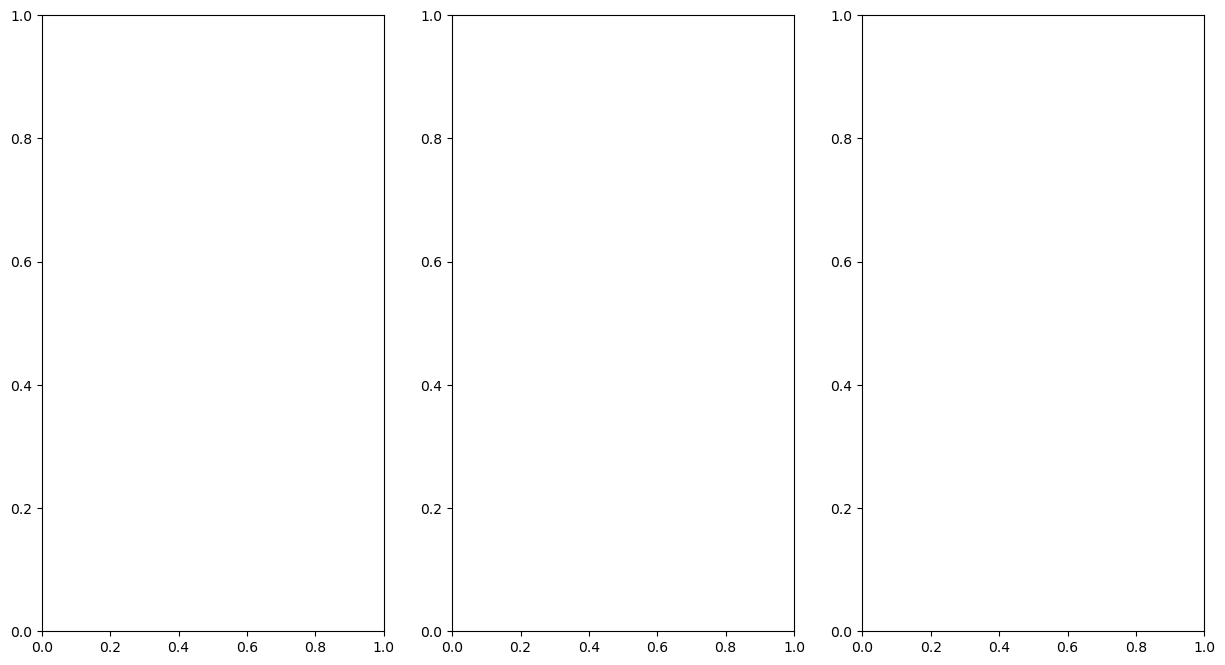

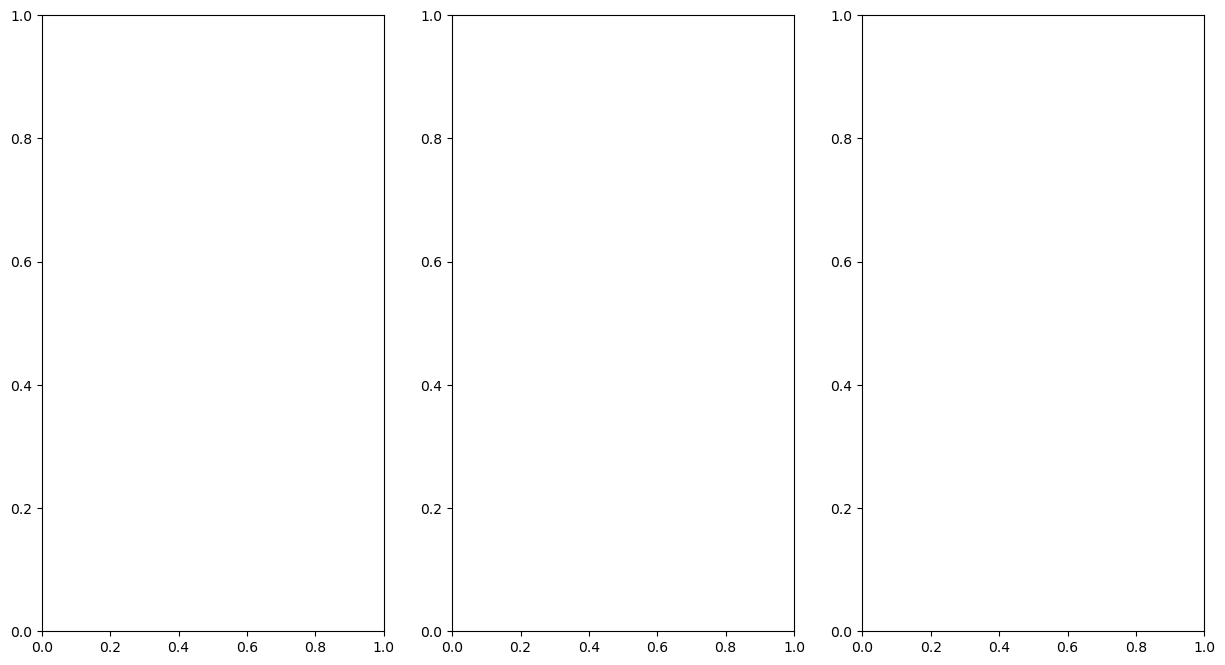

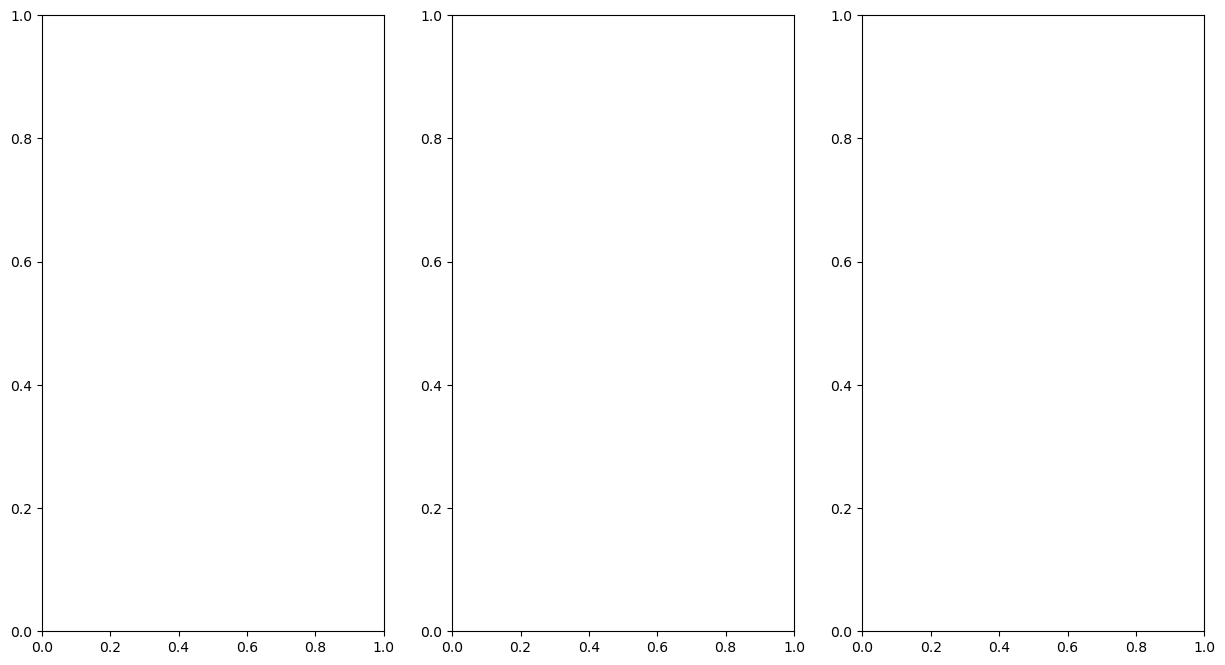

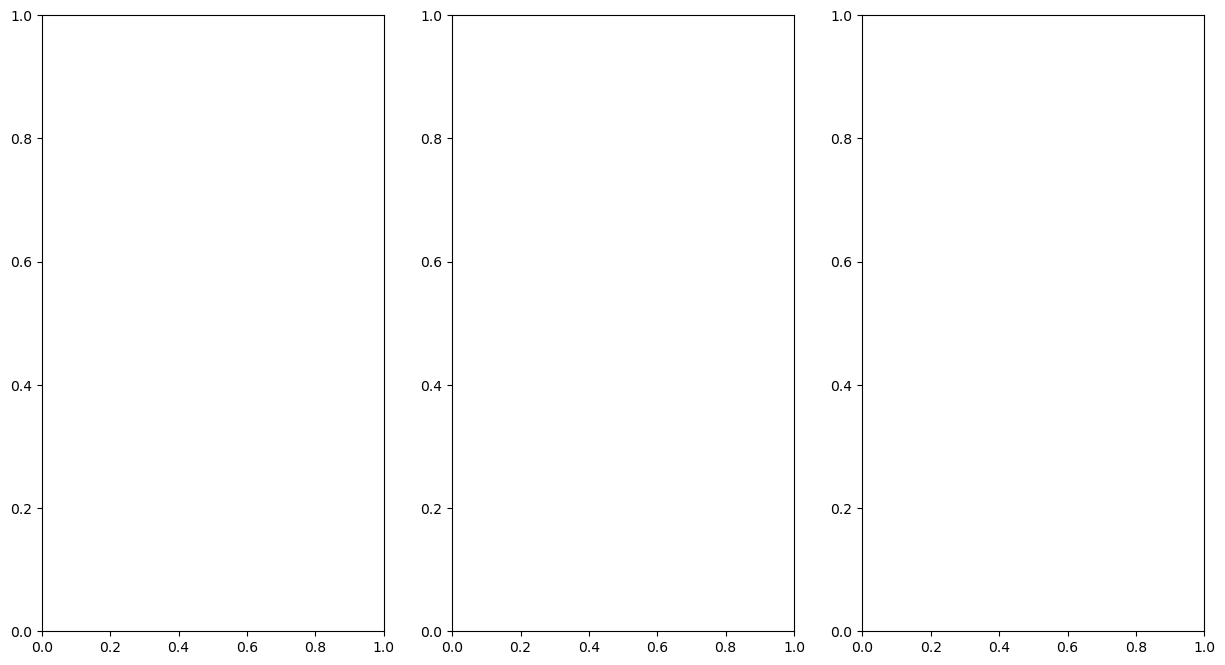

In [14]:
# graphing individual taxa bar graphs for regionYear and each sorting process.
# For the paper, these have been replaced by the advanced graphs at the bottom of the file.
richness_dict = {}
mean_richness_dict = {}
type_colors = ['#75ba75', '#fec76f', '#be95be']
type_colors = ['#3c8c3c', '#e0a03f', '#8c5e8c']
for r, regionYear in enumerate(regionYears):
    regionYear_df = relabund_df[(relabund_df['regionYear'] == regionYear)]
    regionSamples = regionYear_df['FlowCamID'].unique()
    print(regionSamples)
    richness_dict[regionYear] = {}
    mean_richness_dict[regionYear] = {}
    fig, axes = plt.subplots(1, 3, figsize=(15, 8))
    plot_max = plot_maxes[r]
    types = regionYear_df['type'].unique()
    for i, type in enumerate(types):
        regionType_df = regionYear_df[regionYear_df['type'] == type]
        summaryData_df = regionType_df.groupby('newName', as_index=False)['relabund'].mean()
        mean_richness_dict[regionYear][type] = summaryData_df
        newNames = summaryData_df['newName'].to_numpy()
        data = summaryData_df['relabund'].to_numpy()

        # if np.max(data) > plot_max:
        #     plot_max = np.max(data)

        # axes[i].barh(list(range(len(data))), data, color=type_colors[i])
        # presence_array = data>0
        # colors = ['black' if truth else 'darkgrey' for truth in presence_array]
        # # Add labels and title
        # axes[i].set_yticks(ticks=np.array(range(len(newNames))), labels=newNames, rotation=0, fontsize=7)
        # yticks = axes[i].get_yticklabels()
        # for tick, color in zip(yticks, colors):
        #     tick.set_color(color)
        # # Show the plot
        # axes[i].set_title(type)
        # axes[i].set_xlim([0, plot_maxes[r]])
        # axes[i].set_xlabel('Relative Abundance')
        richness_dict[regionYear][type] = {}
        for regionSample in regionSamples:
            regionTypeSample_df = regionType_df[regionType_df['FlowCamID'] == regionSample]
            
            richness_dict[regionYear][type][regionSample] = regionTypeSample_df['relabund'].to_numpy()
    # plot_maxes[r] = plot_max + .02
    # plt.tight_layout(rect=[0, 0, 1, 0.95])
    # plt.suptitle(f'{regionYear}', fontsize=18)

    
    # plt.show()
    # plt.close()

['AMMP_Gulf_StPeters_1_20200903HT_250UM'
 'AMMP_Gulf_StPeters_1_20200903LT_250UM'
 'AMMP_Gulf_StPeters_1_20200904HT_250UM'
 'AMMP_Gulf_StPeters_2B_20200903_250UM'
 'AMMP_Gulf_StPeters_2_20200903HT_250UM'
 'AMMP_Gulf_StPeters_2_20200904HT_250UM'
 'AMMP_Gulf_StPeters_3B_20200903_250UM'
 'AMMP_Gulf_StPeters_3_20200903HT_250UM'
 'AMMP_Gulf_StPeters_3_20200903LT_250UM'
 'AMMP_Gulf_StPeters_3_20200904HT_250UM']


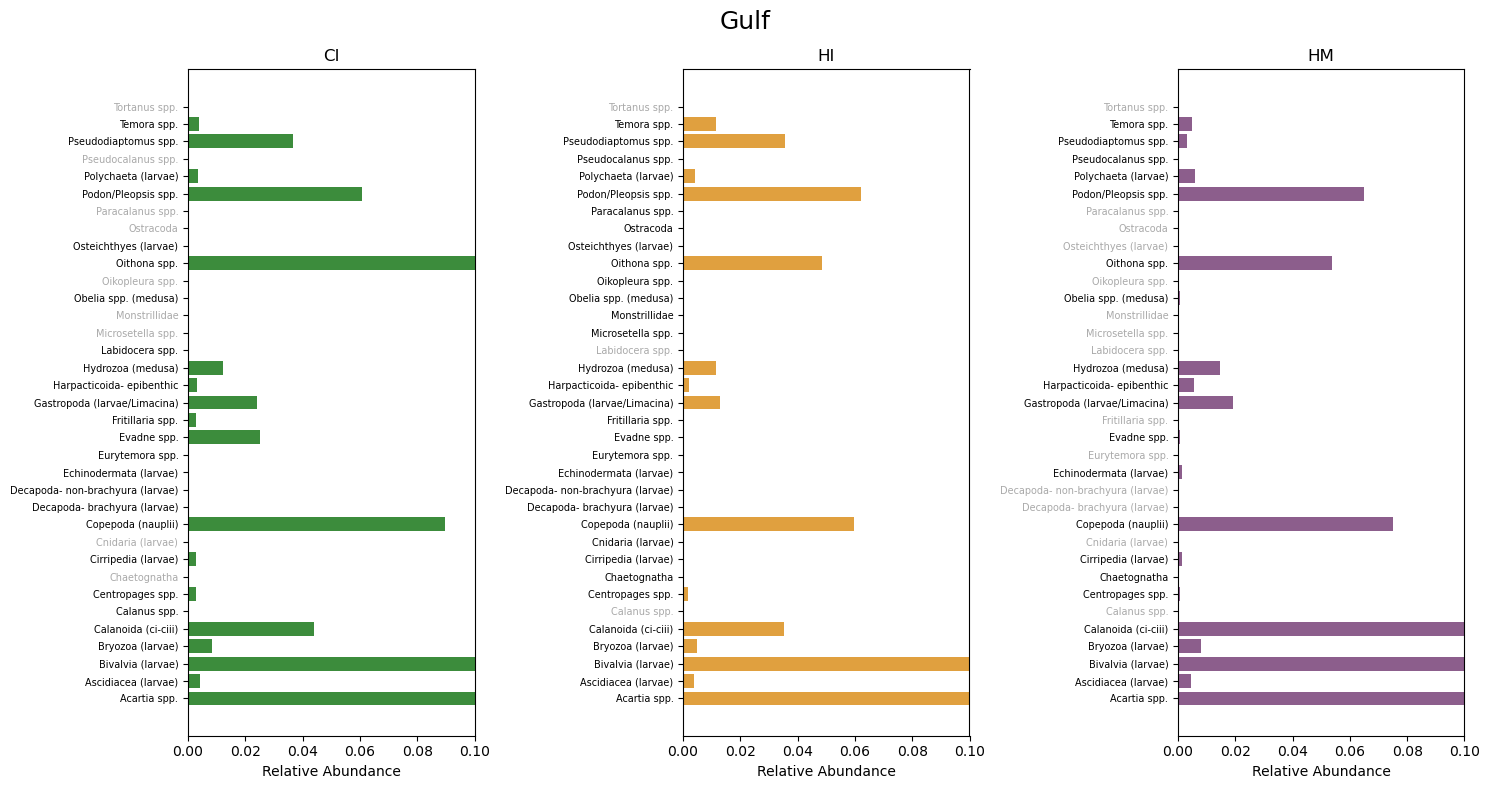

['AMMP_PA_S04W01_20210609HT_250um' 'AMMP_PA_S04W01_20210609LT_250um'
 'AMMP_PA_S04W01_20210610HT_250um' 'AMMP_PA_S04W01_20210610LT_250um'
 'AMMP_PA_S04W15_20210609HT_250um' 'AMMP_PA_S04W15_20210609LT_250um'
 'AMMP_PA_S04W15_20210610LT_250um' 'AMMP_PA_S04W20_20210609HT_250um'
 'AMMP_PA_S04W20_20210609LT_250um' 'AMMP_PA_S04W20_20210610LT_250um']


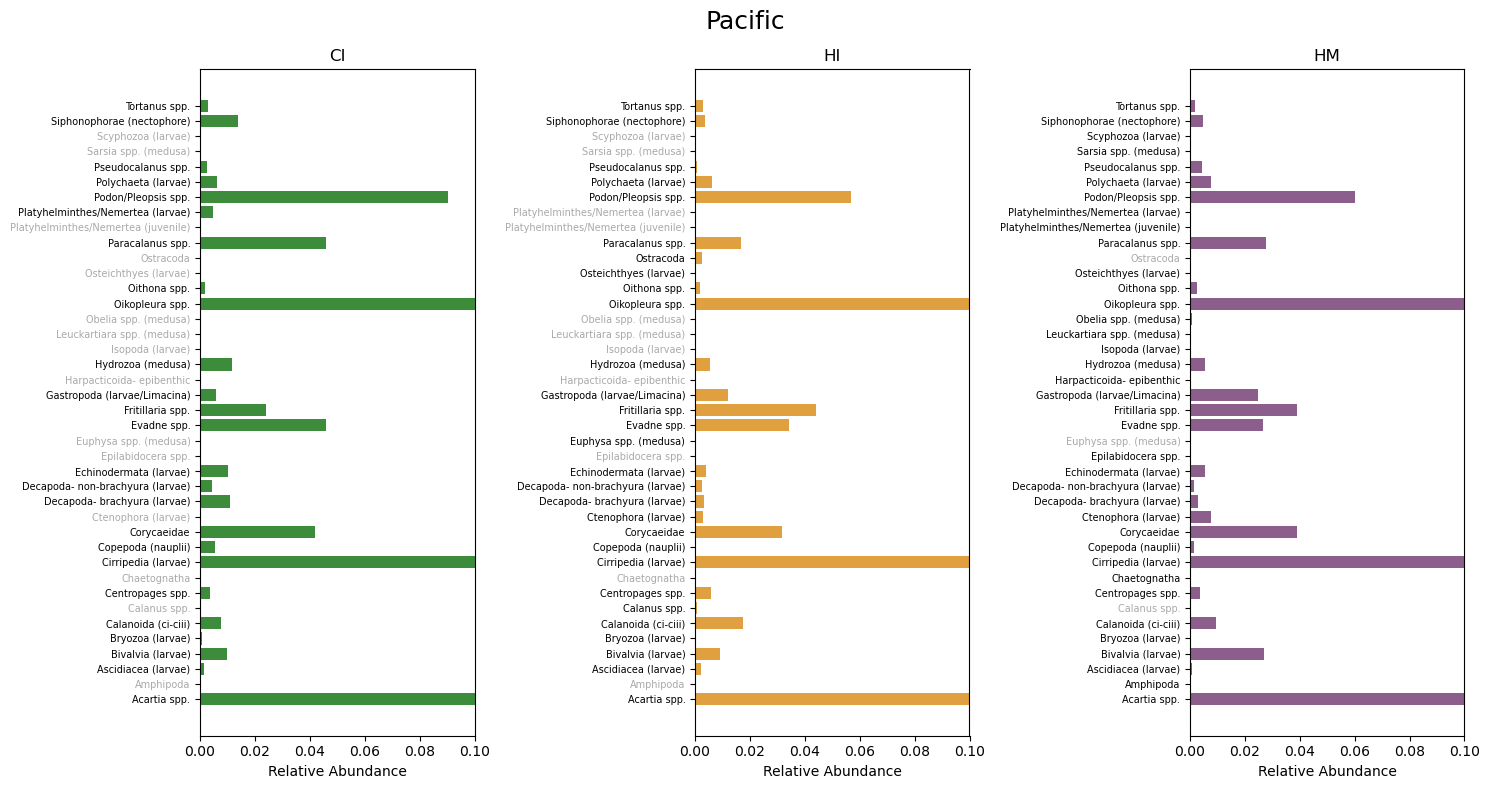

['AMMP_NL_S01_33_20200916AM_250UM' 'AMMP_NL_S01_33_20200916PM_250UM'
 'AMMP_NL_S01_41_20200916AM_250UM' 'AMMP_NL_S01_41_20200916PM_250UM'
 'AMMP_NL_S01_51_20200915PM_250UM' 'AMMP_NL_S01_51_20200916AM_250UM'
 'AMMP_NL_S01_51_20200916PM_250UM' 'AMMP_NL_S01_77_20200915PM_250UM'
 'AMMP_NL_S01_77_20200916AM_250UM' 'AMMP_NL_S01_77_20200916PM_250UM']


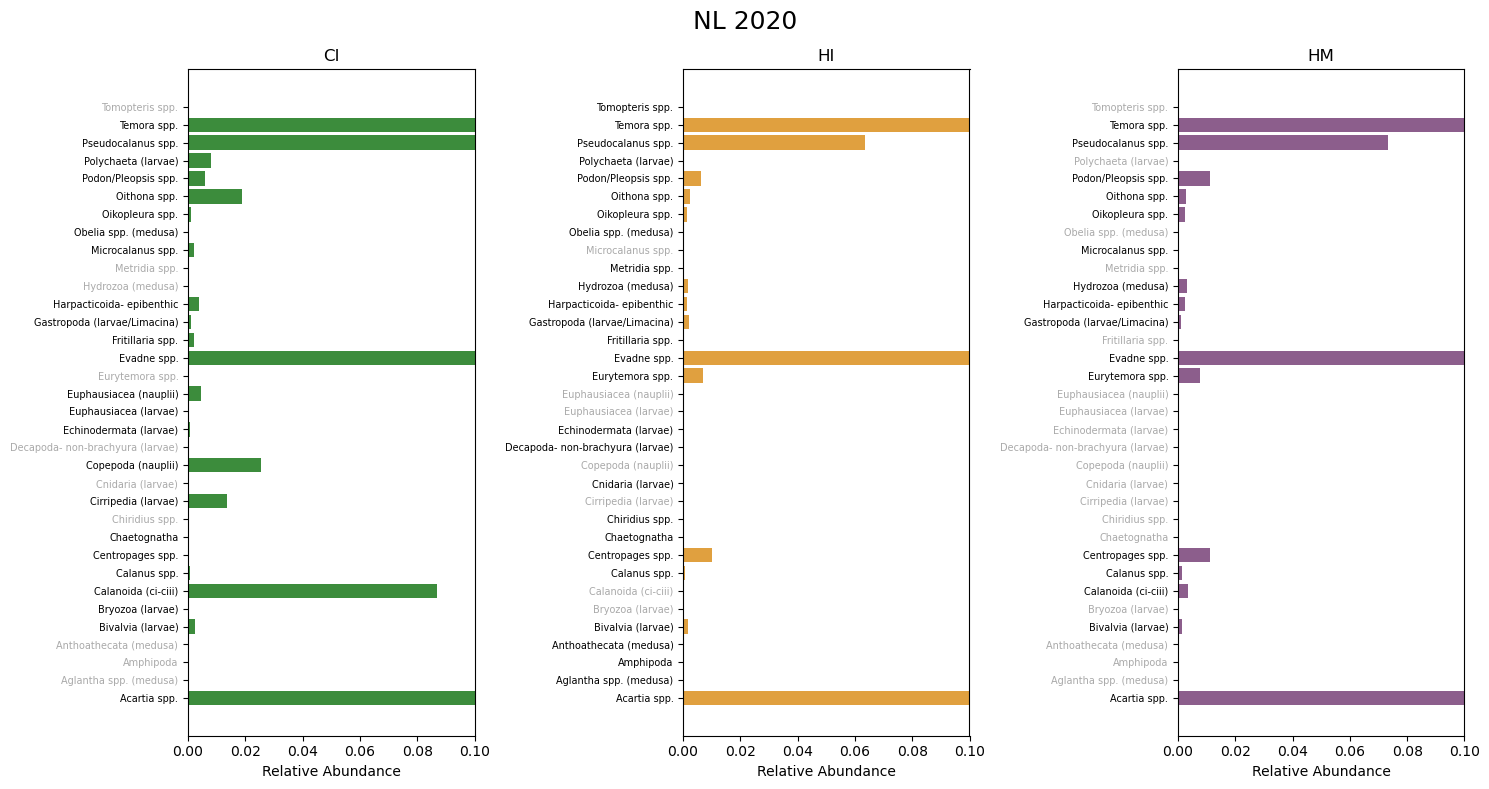

['21_10_05_NL_S1_Z17_0752_250' '21_10_05_NL_S1_Z17_1406_250'
 '21_10_05_NL_S1_Z41_0854_250' '21_10_05_NL_S1_Z41_1327_250'
 '21_10_06_NL_S1_Z17_0802_250' '21_10_06_NL_S1_Z17_1442_250'
 '21_10_06_NL_S1_Z41_0839_250' '21_10_06_NL_S1_Z41_1412_250'
 '21_10_07_NL_S1_Z17_0830_250' '21_10_07_NL_S1_Z17_1459_250']


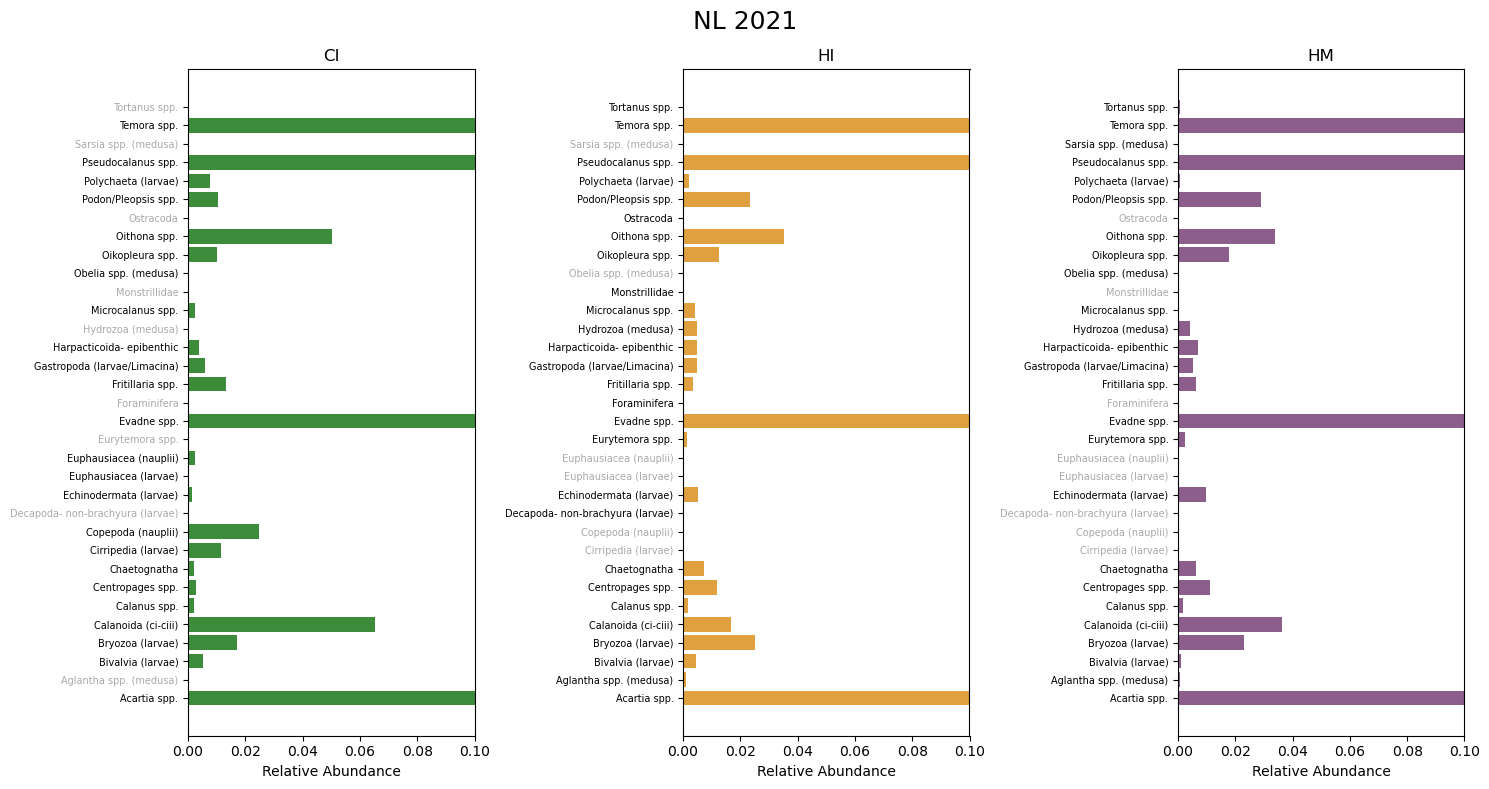

In [15]:
# graphing individual taxa bar graphs for regionYear and each sorting process. FOR MAX GULF
# For the paper, these have been replaced by the advanced graphs at the bottom of the file.
max_richness_dict = {}
max_mean_richness_dict = {}
type_colors = ['#75ba75', '#fec76f', '#be95be']
type_colors = ['#3c8c3c', '#e0a03f', '#8c5e8c']
for r, regionYear in enumerate(regionYears):
    regionYear_df = max_relabund_df[(max_relabund_df['regionYear'] == regionYear)]
    regionSamples = regionYear_df['FlowCamID'].unique()
    print(regionSamples)
    max_richness_dict[regionYear] = {}
    max_mean_richness_dict[regionYear] = {}
    fig, axes = plt.subplots(1, 3, figsize=(15, 8))
    plot_max = plot_maxes[r]
    for i, type in enumerate(types):
        regionType_df = regionYear_df[regionYear_df['type'] == type]
        summaryData_df = regionType_df.groupby('newName', as_index=False)['relabund'].mean()
        max_mean_richness_dict[regionYear][type] = summaryData_df
        newNames = summaryData_df['newName'].to_numpy()
        data = summaryData_df['relabund'].to_numpy()

        if np.max(data) > plot_max:
            plot_max = np.max(data)

        axes[i].barh(list(range(len(data))), data, color=type_colors[i])
        presence_array = data>0
        colors = ['black' if truth else 'darkgrey' for truth in presence_array]
        # Add labels and title
        axes[i].set_yticks(ticks=np.array(range(len(newNames))), labels=newNames, rotation=0, fontsize=7)
        yticks = axes[i].get_yticklabels()
        for tick, color in zip(yticks, colors):
            tick.set_color(color)
        # Show the plot
        axes[i].set_title(type)
        axes[i].set_xlim([0, plot_maxes[r]])
        axes[i].set_xlabel('Relative Abundance')
        max_richness_dict[regionYear][type] = {}
        for regionSample in regionSamples:
            regionTypeSample_df = regionType_df[regionType_df['FlowCamID'] == regionSample]
            
            max_richness_dict[regionYear][type][regionSample] = regionTypeSample_df['relabund'].to_numpy()
    plot_maxes[r] = plot_max + .02
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.suptitle(f'{regionYear}', fontsize=18)

    
    plt.show()
    plt.close()

In [16]:
#Organize data for BOXPLOTS
count = 0
box_plot_data = {}
shannon_box_data = {}
pielou_box_data = {}
regional_richness = {}

for regionYear in regionYears:
    box_plot_data[regionYear] = []
    shannon_box_data[regionYear] = []
    pielou_box_data[regionYear] = []
    regional_richness[regionYear] = []
    regionYear_df = relabund_df[(relabund_df['regionYear'] == regionYear)]
    types = regionYear_df['type'].unique()
    print(regionYear, types)
    for t, type in enumerate(types):
        total_richness = mean_richness_dict[regionYear][type]['relabund'].to_numpy()
        valid_richness = [x for x in total_richness if x > 0]
        print(len(valid_richness))
        regional_richness[regionYear].append(len(valid_richness))
        box_plot_data[regionYear].append([])
        shannon_box_data[regionYear].append([])
        pielou_box_data[regionYear].append([])
        for sample in richness_dict[regionYear][type].keys():
            count +=  1
            abundances = richness_dict[regionYear][type][sample]
            actual_abund = [x for x in abundances if x > 0]
            box_plot_data[regionYear][t].append(len(actual_abund))
            shannon = shannon_diversity_index(abundances)
            shannon_box_data[regionYear][t].append(shannon)
            pielou = pielou_evenness_index(abundances)
            pielou_box_data[regionYear][t].append(pielou)
box_plot_data

Gulf ['CI' 'HI' 'HM' 'CI-u']
29
32
21
26
Pacific ['CI' 'HI' 'HM']
25
29
37
NL 2020 ['CI' 'HI' 'HM']
24
27
16
NL 2021 ['CI' 'HI' 'HM']
24
27
25


{'Gulf': [[27, 26, 26, 26, 23, 24, 23, 23, 27, 23],
  [23, 15, 27, 13, 13, 12, 8, 9, 19, 12],
  [14, 9, 17, 9, 8, 10, 5, 9, 17, 7],
  [24, 23, 24, 21, 19, 21, 18, 17, 22, 19]],
 'Pacific': [[24, 24, 24, 25, 25, 22, 24, 24, 24, 24],
  [24, 25, 24, 22, 23, 23, 23, 22, 22, 25],
  [21, 25, 26, 24, 20, 28, 24, 23, 26, 27]],
 'NL 2020': [[20, 22, 23, 22, 21, 18, 21, 16, 20, 19],
  [17, 17, 21, 20, 17, 16, 16, 11, 14, 15],
  [11, 14, 10, 8, 8, 9, 9, 8, 9, 11]],
 'NL 2021': [[21, 21, 21, 20, 22, 23, 22, 20, 20, 20],
  [22, 19, 22, 19, 21, 20, 21, 21, 22, 21],
  [18, 19, 18, 18, 17, 19, 19, 20, 17, 15]]}

In [17]:

for regionYear in regionYears:
    print('-------------------')
    print(regionYear)
    print('-------------------')
    for t, type in enumerate(box_plot_data[regionYear]):
        print(type)
        datarow = box_plot_data[regionYear][t]
        # print(datarow)
        print("richness mean: ", np.mean(datarow))
        se = np.std(datarow, ddof=1)/np.sqrt(len(datarow))
        print("richness se: ", se)

for regionYear in regionYears:
    print('-------------------')
    print(regionYear)
    print('-------------------')
    for t, type in enumerate(pielou_box_data[regionYear]):
        print(type)
        datarow = pielou_box_data[regionYear][t]
        # print(datarow)
        print("pielou mean: ", np.mean(datarow))
        se = np.std(datarow, ddof=1)/np.sqrt(len(datarow))
        print("pielou se: ", se)
for regionYear in regionYears:
    print('-------------------')
    print(regionYear)
    print('-------------------')
    for t, type in enumerate(shannon_box_data[regionYear]):
        print(type)
        datarow = shannon_box_data[regionYear][t]
        # print(datarow)
        print("shannon mean: ", np.mean(datarow))
        se = np.std(datarow, ddof=1)/np.sqrt(len(datarow))
        print("shannon se: ", se)

-------------------
Gulf
-------------------
[27, 26, 26, 26, 23, 24, 23, 23, 27, 23]
richness mean:  24.8
richness se:  0.5537749241945383
[23, 15, 27, 13, 13, 12, 8, 9, 19, 12]
richness mean:  15.1
richness se:  1.9290181728307045
[14, 9, 17, 9, 8, 10, 5, 9, 17, 7]
richness mean:  10.5
richness se:  1.3017082793177754
[24, 23, 24, 21, 19, 21, 18, 17, 22, 19]
richness mean:  20.8
richness se:  0.7859884081701063
-------------------
Pacific
-------------------
[24, 24, 24, 25, 25, 22, 24, 24, 24, 24]
richness mean:  24.0
richness se:  0.2581988897471611
[24, 25, 24, 22, 23, 23, 23, 22, 22, 25]
richness mean:  23.3
richness se:  0.36666666666666664
[21, 25, 26, 24, 20, 28, 24, 23, 26, 27]
richness mean:  24.4
richness se:  0.8055363982396381
-------------------
NL 2020
-------------------
[20, 22, 23, 22, 21, 18, 21, 16, 20, 19]
richness mean:  20.2
richness se:  0.6633249580710799
[17, 17, 21, 20, 17, 16, 16, 11, 14, 15]
richness mean:  16.4
richness se:  0.8969082698049139
[11, 14, 10

In [18]:
mx = box_plot_data['Gulf'].pop()
box_plot_data['Gulf'] = [mx] + box_plot_data['Gulf']
mx = pielou_box_data['Gulf'].pop()
pielou_box_data['Gulf'] = [mx] + pielou_box_data['Gulf']

richness
{'Gulf': [[24, 23, 24, 21, 19, 21, 18, 17, 22, 19], [27, 26, 26, 26, 23, 24, 23, 23, 27, 23], [23, 15, 27, 13, 13, 12, 8, 9, 19, 12], [14, 9, 17, 9, 8, 10, 5, 9, 17, 7]], 'Pacific': [[24, 24, 24, 25, 25, 22, 24, 24, 24, 24], [24, 25, 24, 22, 23, 23, 23, 22, 22, 25], [21, 25, 26, 24, 20, 28, 24, 23, 26, 27]], 'NL 2020': [[20, 22, 23, 22, 21, 18, 21, 16, 20, 19], [17, 17, 21, 20, 17, 16, 16, 11, 14, 15], [11, 14, 10, 8, 8, 9, 9, 8, 9, 11]], 'NL 2021': [[21, 21, 21, 20, 22, 23, 22, 20, 20, 20], [22, 19, 22, 19, 21, 20, 21, 21, 22, 21], [18, 19, 18, 18, 17, 19, 19, 20, 17, 15]]}
['CI' 'HI' 'HM' 'CI-u']
['CI' 'HI' 'HM']
['CI' 'HI' 'HM']
['CI' 'HI' 'HM']
0
[2, 28]
1
[3, 28]
2
[4, 19]
3
[1, 25]
4
[2, 24]
5
[3, 15]
6
[3, 21]


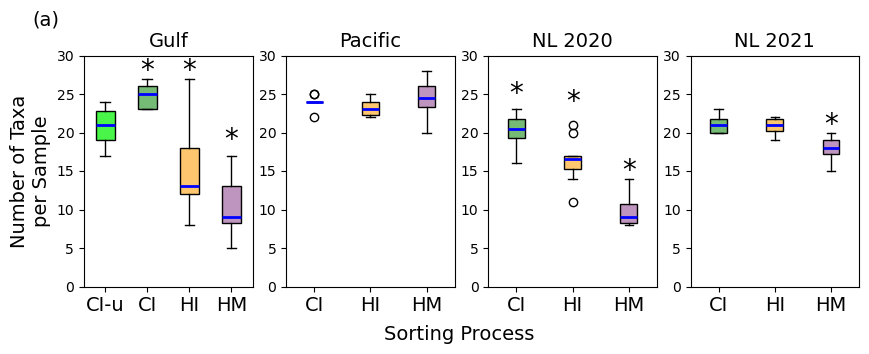

Shannon
{'Gulf': [[1.7637827883297272, 2.258686223109199, 1.6454628564387141, 1.9429624701302726, 2.1075384228227403, 1.9312071811594502, 1.9381517076988506, 2.1440136488939605, 2.2440941883386896, 1.9774902845954097], [1.5665307954993732, 1.1425488377725896, 1.5185012848025565, 0.7155391909894563, 1.0098670263721559, 0.8212345269349397, 0.6930954353595433, 0.8954610858457002, 2.105218443790747, 0.5990972083015822], [1.3479374629942587, 1.4334395203320376, 2.074424638484777, 1.2138290002461587, 1.2202536116651217, 1.196131007982451, 1.1624074191276679, 1.359690064381611, 2.0647164432065974, 1.235966856548696], [1.7101041073030383, 1.729639108841563, 1.6332342631879455, 1.2997927099219901, 1.720626144020582, 1.4382050693507544, 1.4518012279756587, 1.8005204068418972, 2.1260392177560754, 1.5194800439726848]], 'Pacific': [[2.1488980618877487, 2.2179239121202627, 2.234470921534311, 2.230447502673163, 2.238974075032026, 2.1098864279008147, 2.1956325044600464, 2.187893576681545, 2.1015022966

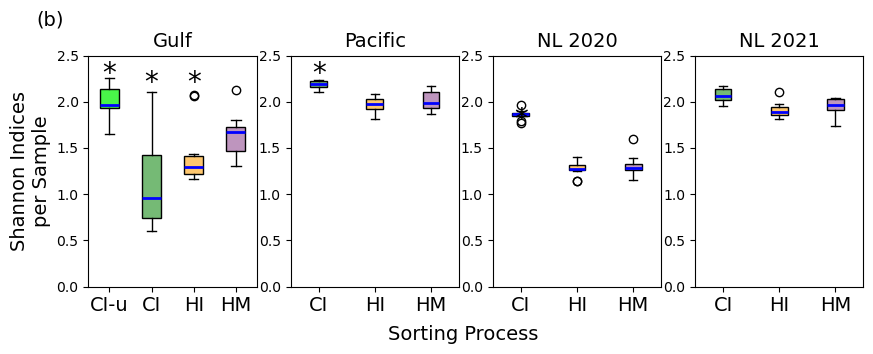

Pielou
{'Gulf': [[0.538097904753177, 0.5516320521513111, 0.5139101948468672, 0.42692827414138723, 0.5843646807405344, 0.47239102314719317, 0.502288753690422, 0.6355047037383188, 0.6878065409442059, 0.5160507841133267], [0.5351547603956592, 0.6932533142436637, 0.505038091178827, 0.5963489563480399, 0.672155098266768, 0.6076697514428238, 0.6181327644785697, 0.6837881052376998, 0.6808875194903964, 0.6306789770331037], [0.4996120826952822, 0.4219082930248332, 0.460733145036846, 0.27896815541715286, 0.39371811510991966, 0.33048908577913916, 0.33330844915199676, 0.40754190312730904, 0.7149811759341423, 0.2410944525230733], [0.5107647521968653, 0.6523864402016892, 0.7321808796491454, 0.5524373852206453, 0.5868179447253727, 0.5194730964001528, 0.7222443376952968, 0.6188216163274561, 0.7287543126740369, 0.6351613188043264]], 'Pacific': [[0.6761679243338931, 0.6978874589664945, 0.7030941075311089, 0.6929274765560397, 0.6955764051953457, 0.682580863814566, 0.6908732896508741, 0.688438174265288, 0

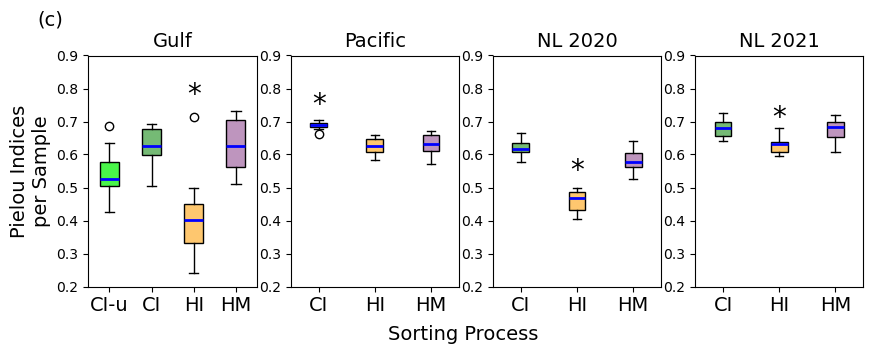

In [19]:
'''FUNCTION FOR DISPLAYING BOXPLOTS
    data = the boxplot data
    ylim = the y-axis limits for the plots
    asterisk_indices = an array of which boxes (regionYears) have asterisks (significant differences)
    asterisk_locs = x and y locations of each asterisk within its subplot
    title = title of each subplot
    figuretitle = title of the whole plot
    return void
'''
def display_boxplots(data, ylim, asterisk_indices, asterisk_locs, title, figuretitle):
    print(data)
    fig, axes = plt.subplots(1, 4, figsize=(10, 3))
    for r, regionYear in enumerate(regionYears):
        types = relabund_df[relabund_df['regionYear'] == regionYear]['type'].unique()
        print(types)
        
        ax = axes[r]
        bplot = ax.boxplot(data[regionYear], patch_artist=True, medianprops=dict(color='blue', linewidth=2))
        # Set x-ticks labels for each boxplot
        colors = ['#75ba75', '#fec76f', '#be95be']
        if len(types) > 3:
            types = list(types)
            types = [types[3]] + types[:3]
            colors = ['#49f549', '#75ba75', '#fec76f', '#be95be']
        ax.set_xticks(range(1, len(types) + 1), types, fontsize=14)
        # ax.set_yticks([])
        # if regionYear != 'Gulf':
        #     ax.tick_params(axis='y', labelleft=False)  
        # ax.set_xticks()
        # Add title and labels
        ax.set_title(regionYear, fontsize=14)
        ax.set_ylim(ylim)
        
    # fill with colors
        for patch, color in zip(bplot['boxes'], colors):
            patch.set_facecolor(color)
        # ax.set_xlabel('Classification Method')
        # ax.set_ylabel('Number of Unique Taxa per Sample')
    
    # Set a single y-label on the left side for all subplots
    axes[0].set_ylabel(f"{title}\nper Sample", fontsize=14)
    for i, index in enumerate(asterisk_indices):
        print(i)
        print(asterisk_locs[i])
        axes[index].text(asterisk_locs[i][0], asterisk_locs[i][1], '*', fontsize=20, color='black', ha='center', va='center')
    
    # Set a single x-label at the bottom in the center for all subplots
    fig.text(0.5, -0.05, "Sorting Process", ha='center', va='center', fontsize=14)
    fig.text(0.1, 1, f"({figuretitle})", ha='right', va='center', fontsize=14)  
    # Show the plot
    plt.show()
    plt.close()
print('richness')

display_boxplots(box_plot_data, [0, 30], [0, 0, 0, 2, 2, 2, 3], [[2, 28], [3, 28], [4, 19], [1, 25], [2, 24], [3, 15], [3, 21]], 'Number of Taxa', 'a')
print('Shannon')
display_boxplots(shannon_box_data, [0, 2.5], [0, 0, 0, 1, 2], [[1, 2.3], [2, 2.2], [3, 2.2], [1, 2.3], [1, 1.8]], 'Shannon Indices', 'b')
print('Pielou')
display_boxplots(pielou_box_data, [0.2, .9], [0, 1, 2, 3], [[3, .78],[1, .75], [2, .55], [2, .71]], 'Pielou Indices', 'c')

In [20]:
box_plot_data

{'Gulf': [[24, 23, 24, 21, 19, 21, 18, 17, 22, 19],
  [27, 26, 26, 26, 23, 24, 23, 23, 27, 23],
  [23, 15, 27, 13, 13, 12, 8, 9, 19, 12],
  [14, 9, 17, 9, 8, 10, 5, 9, 17, 7]],
 'Pacific': [[24, 24, 24, 25, 25, 22, 24, 24, 24, 24],
  [24, 25, 24, 22, 23, 23, 23, 22, 22, 25],
  [21, 25, 26, 24, 20, 28, 24, 23, 26, 27]],
 'NL 2020': [[20, 22, 23, 22, 21, 18, 21, 16, 20, 19],
  [17, 17, 21, 20, 17, 16, 16, 11, 14, 15],
  [11, 14, 10, 8, 8, 9, 9, 8, 9, 11]],
 'NL 2021': [[21, 21, 21, 20, 22, 23, 22, 20, 20, 20],
  [22, 19, 22, 19, 21, 20, 21, 21, 22, 21],
  [18, 19, 18, 18, 17, 19, 19, 20, 17, 15]]}

In [21]:
from scipy import stats
import numpy as np

#log_transformed_data = np.log(data)
def test_assumptions(dataset):
    for regionYear in regionYears:
        print('-------------------', regionYear, '------------------------')
        for type in range(3):
            print(regionYear, type)
            data = dataset[regionYear][type]    
            # Perform the Shapiro-Wilk test
            statistic, p_value = stats.shapiro(data)
            
            # Print results
            print(f"Shapiro-Wilk Test Statistic: {statistic}")
            print(f"P-value: {p_value}")
        
            # Interpret the result
            if p_value > 0.05:
                print(f"The data is normally distributed (p = {p_value:.3f})")
            else:
                print('NOT NORMAL----------------------------------------')
                print(f"The data is not normally distributed (p = {p_value:.3f})")
        print('###########', 'Levene Time', '################')
        for combo in [[0, 1], [0, 2], [1, 2]]:
            
            # Perform Levene's test for homogeneity of variances
            stat, p_value = stats.levene(dataset[regionYear][combo[0]] , dataset[regionYear][combo[1]])
            # Print the test statistic and p-value
            print(f"Levene's test statistic: {stat}")
            print(f"P-value: {p_value}")
test_assumptions(pielou_box_data)

------------------- Gulf ------------------------
Gulf 0
Shapiro-Wilk Test Statistic: 0.9670036138133644
P-value: 0.8617588936296492
The data is normally distributed (p = 0.862)
Gulf 1
Shapiro-Wilk Test Statistic: 0.9079658851698454
P-value: 0.2673090462624319
The data is normally distributed (p = 0.267)
Gulf 2
Shapiro-Wilk Test Statistic: 0.9098848852103784
P-value: 0.28020124098347265
The data is normally distributed (p = 0.280)
########### Levene Time ################
Levene's test statistic: 0.11437698098933163
P-value: 0.7391276349299405
Levene's test statistic: 1.1749977477992481
P-value: 0.29268314518188066
Levene's test statistic: 1.8641003379496828
P-value: 0.18897412342725772
------------------- Pacific ------------------------
Pacific 0
Shapiro-Wilk Test Statistic: 0.9407011697394974
P-value: 0.5608416302832446
The data is normally distributed (p = 0.561)
Pacific 1
Shapiro-Wilk Test Statistic: 0.9391719035044644
P-value: 0.5438362756921731
The data is normally distributed (p

------------------- Gulf ------------------------
Gulf 0
before:  [24, 23, 24, 21, 19, 21, 18, 17, 22, 19]
after:  [3.17805383 3.13549422 3.17805383 3.04452244 2.94443898 3.04452244
 2.89037176 2.83321334 3.09104245 2.94443898]


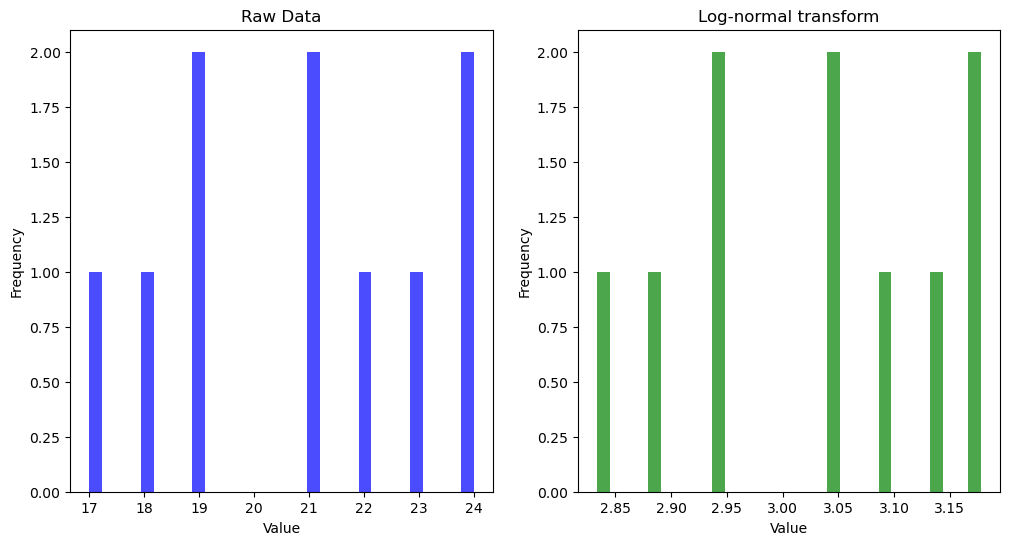

Shapiro-Wilk Test Statistic: 0.935969332632477
P-value: 0.5090940896641143
The data is normally distributed (p = 0.509)
Gulf 1
before:  [27, 26, 26, 26, 23, 24, 23, 23, 27, 23]
after:  [3.29583687 3.25809654 3.25809654 3.25809654 3.13549422 3.17805383
 3.13549422 3.13549422 3.29583687 3.13549422]


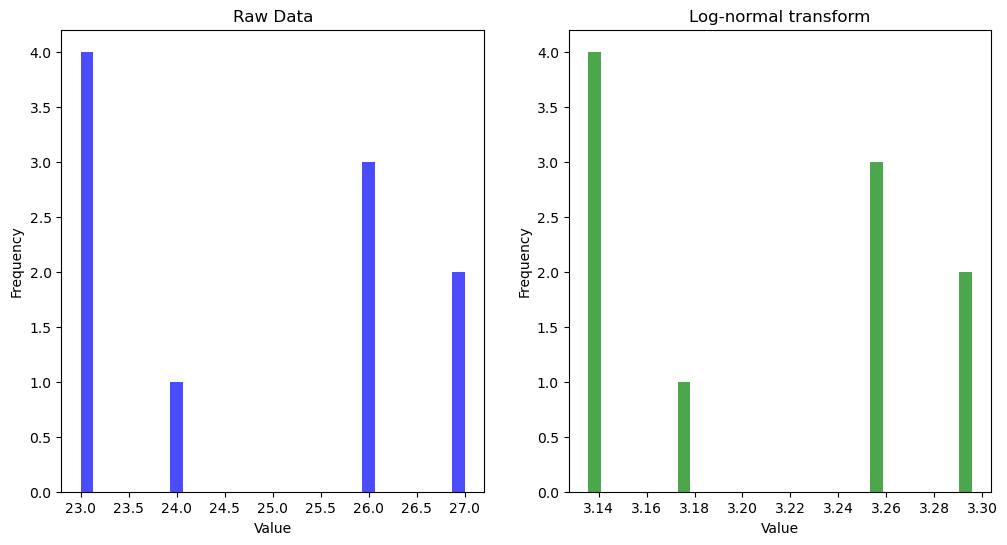

Shapiro-Wilk Test Statistic: 0.7982769533750977
P-value: 0.013815979045187332
NOT NORMAL----------------------------------------
The data is not normally distributed (p = 0.014)
Gulf 2
before:  [23, 15, 27, 13, 13, 12, 8, 9, 19, 12]
after:  [3.13549422 2.7080502  3.29583687 2.56494936 2.56494936 2.48490665
 2.07944154 2.19722458 2.94443898 2.48490665]


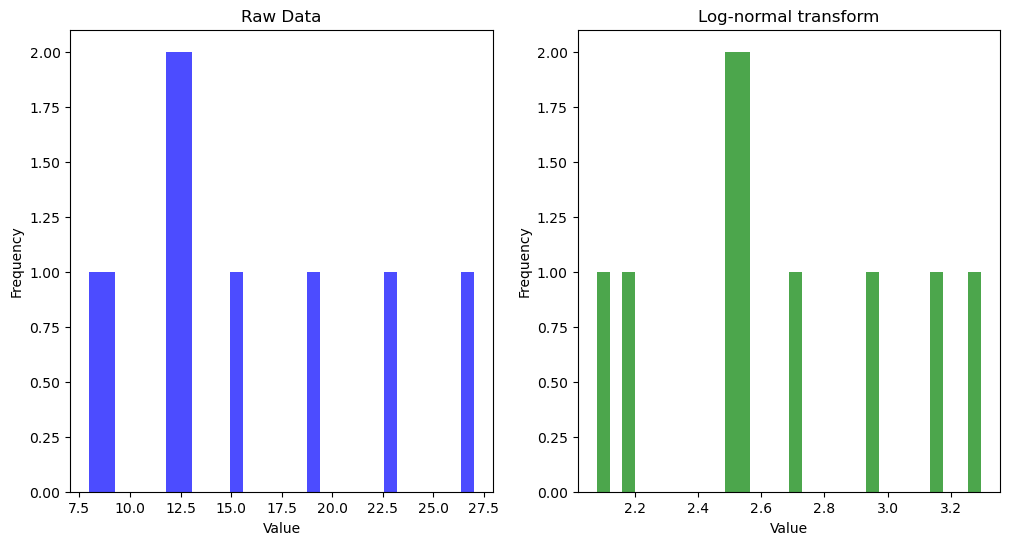

Shapiro-Wilk Test Statistic: 0.955412719903171
P-value: 0.7325703566014491
The data is normally distributed (p = 0.733)
########### Levene Time ################
Levene's test statistic: 0.7826086956521736
P-value: 0.38800910715171844
Levene's test statistic: 2.2660637791527845
P-value: 0.14958183594284796
Levene's test statistic: 3.338931297709923
P-value: 0.0842866888620943
------------------- Pacific ------------------------
Pacific 0
before:  [24, 24, 24, 25, 25, 22, 24, 24, 24, 24]
after:  [3.17805383 3.17805383 3.17805383 3.21887582 3.21887582 3.09104245
 3.17805383 3.17805383 3.17805383 3.17805383]


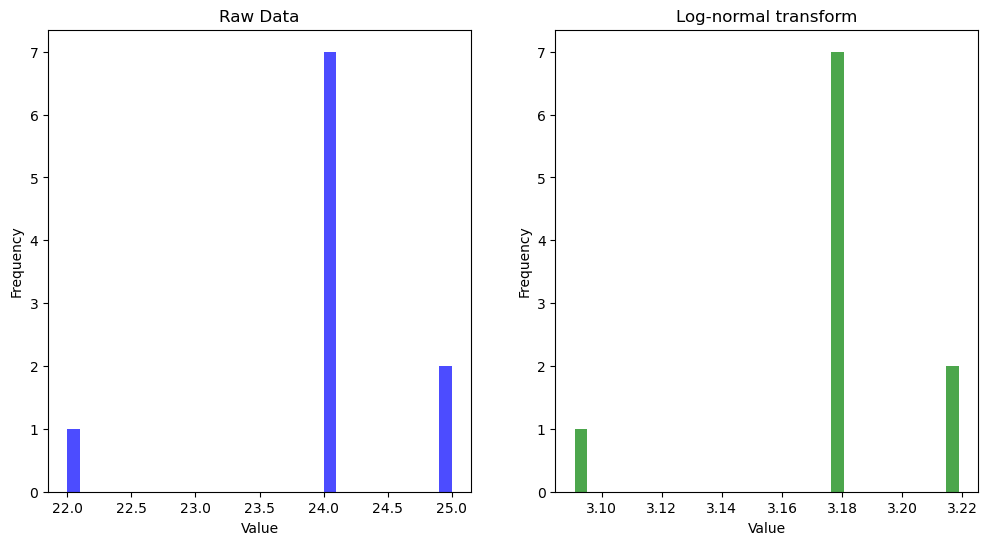

Shapiro-Wilk Test Statistic: 0.6906611944895807
P-value: 0.0006789738757677567
NOT NORMAL----------------------------------------
The data is not normally distributed (p = 0.001)
Pacific 1
before:  [24, 25, 24, 22, 23, 23, 23, 22, 22, 25]
after:  [3.17805383 3.21887582 3.17805383 3.09104245 3.13549422 3.13549422
 3.13549422 3.09104245 3.09104245 3.21887582]


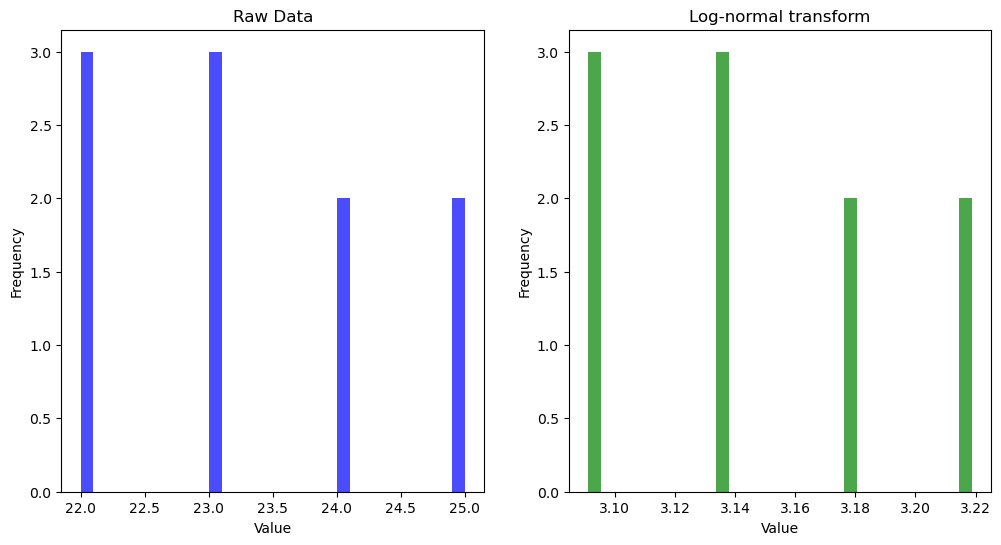

Shapiro-Wilk Test Statistic: 0.8796173491622759
P-value: 0.12917951796034488
The data is normally distributed (p = 0.129)
Pacific 2
before:  [21, 25, 26, 24, 20, 28, 24, 23, 26, 27]
after:  [3.04452244 3.21887582 3.25809654 3.17805383 2.99573227 3.33220451
 3.17805383 3.13549422 3.25809654 3.29583687]


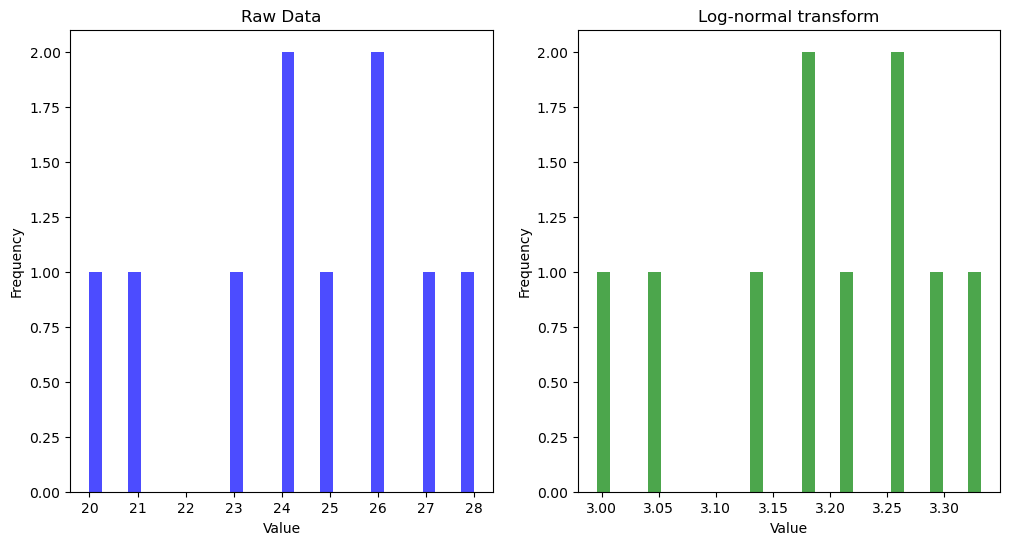

Shapiro-Wilk Test Statistic: 0.9476053310604593
P-value: 0.6402624193436246
The data is normally distributed (p = 0.640)
########### Levene Time ################
Levene's test statistic: 2.419354838709677
P-value: 0.13725108337569447
Levene's test statistic: 10.06113537117904
P-value: 0.00527814866859395
Levene's test statistic: 4.653846153846154
P-value: 0.04474830490334333
------------------- NL 2020 ------------------------
NL 2020 0
before:  [20, 22, 23, 22, 21, 18, 21, 16, 20, 19]
after:  [2.99573227 3.09104245 3.13549422 3.09104245 3.04452244 2.89037176
 3.04452244 2.77258872 2.99573227 2.94443898]


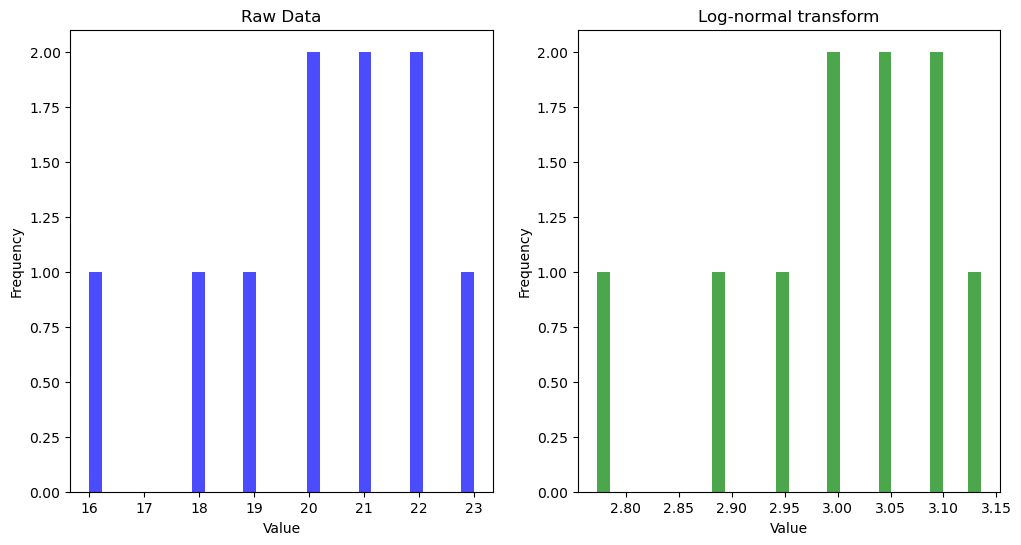

Shapiro-Wilk Test Statistic: 0.9298704360950947
P-value: 0.4466189732351094
The data is normally distributed (p = 0.447)
NL 2020 1
before:  [17, 17, 21, 20, 17, 16, 16, 11, 14, 15]
after:  [2.83321334 2.83321334 3.04452244 2.99573227 2.83321334 2.77258872
 2.77258872 2.39789527 2.63905733 2.7080502 ]


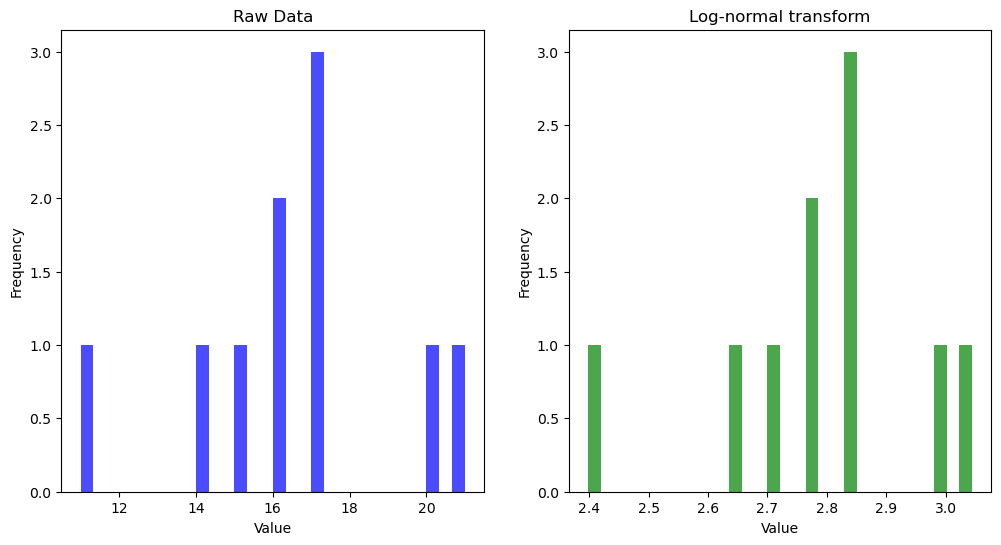

Shapiro-Wilk Test Statistic: 0.9310011401044566
P-value: 0.45781152170723743
The data is normally distributed (p = 0.458)
NL 2020 2
before:  [11, 14, 10, 8, 8, 9, 9, 8, 9, 11]
after:  [2.39789527 2.63905733 2.30258509 2.07944154 2.07944154 2.19722458
 2.19722458 2.07944154 2.19722458 2.39789527]


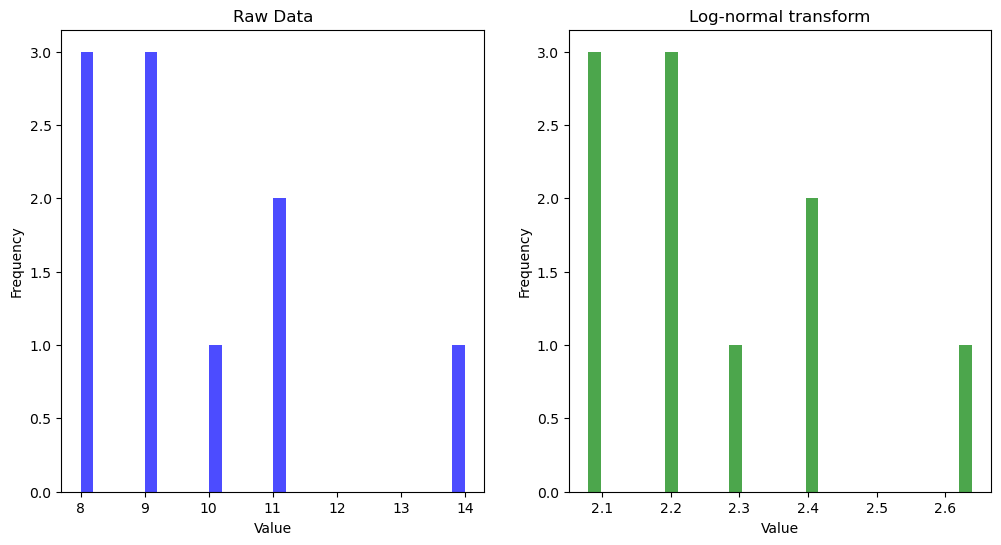

Shapiro-Wilk Test Statistic: 0.8772213835568455
P-value: 0.1212290821282524
The data is normally distributed (p = 0.121)
########### Levene Time ################
Levene's test statistic: 0.3037974683544302
P-value: 0.5882886233364274
Levene's test statistic: 0.2314285714285715
P-value: 0.6362624107925002
Levene's test statistic: 0.838403041825095
P-value: 0.37195844257423294
------------------- NL 2021 ------------------------
NL 2021 0
before:  [21, 21, 21, 20, 22, 23, 22, 20, 20, 20]
after:  [3.04452244 3.04452244 3.04452244 2.99573227 3.09104245 3.13549422
 3.09104245 2.99573227 2.99573227 2.99573227]


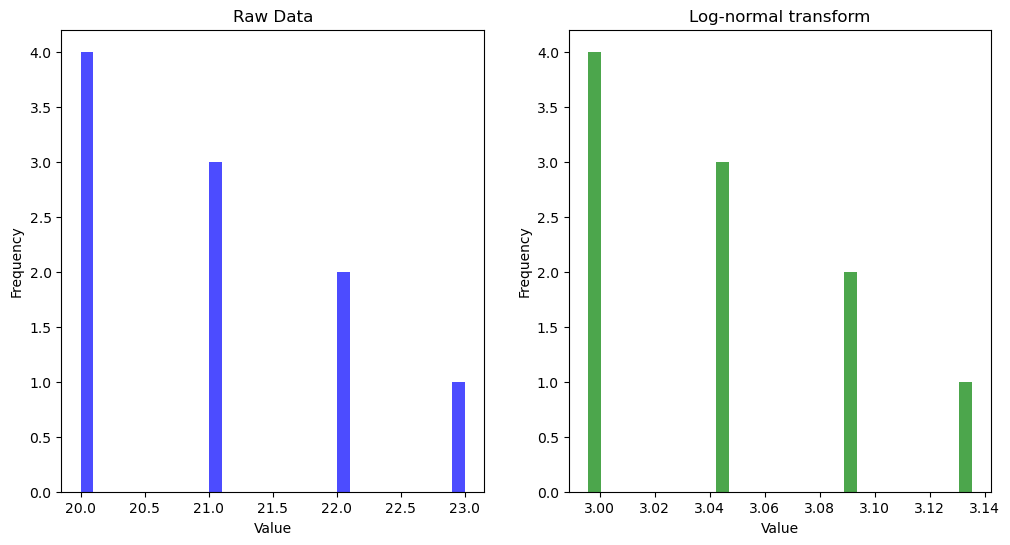

Shapiro-Wilk Test Statistic: 0.8606698628695385
P-value: 0.07770897865676595
The data is normally distributed (p = 0.078)
NL 2021 1
before:  [22, 19, 22, 19, 21, 20, 21, 21, 22, 21]
after:  [3.09104245 2.94443898 3.09104245 2.94443898 3.04452244 2.99573227
 3.04452244 3.04452244 3.09104245 3.04452244]


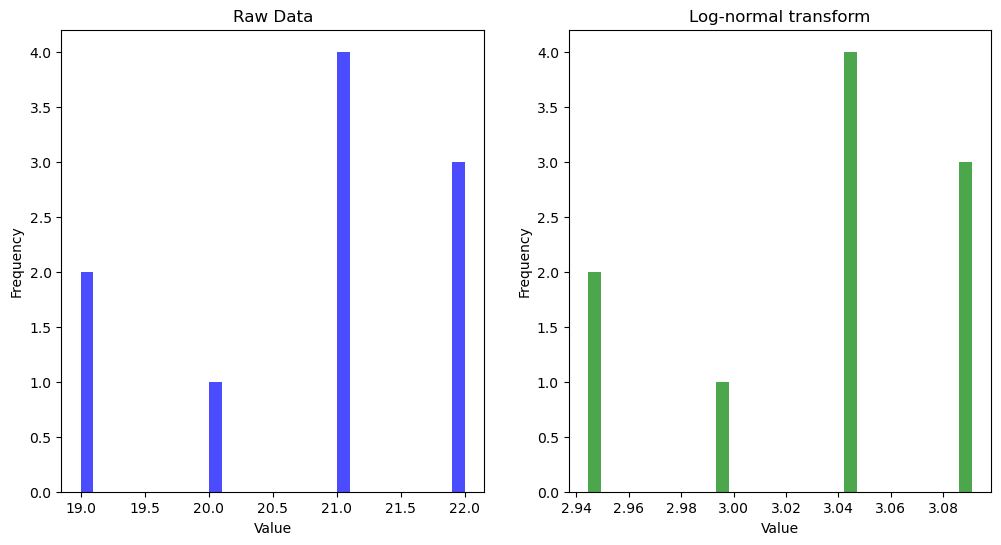

Shapiro-Wilk Test Statistic: 0.8422241823813397
P-value: 0.04691458429913016
NOT NORMAL----------------------------------------
The data is not normally distributed (p = 0.047)
NL 2021 2
before:  [18, 19, 18, 18, 17, 19, 19, 20, 17, 15]
after:  [2.89037176 2.94443898 2.89037176 2.89037176 2.83321334 2.94443898
 2.94443898 2.99573227 2.83321334 2.7080502 ]


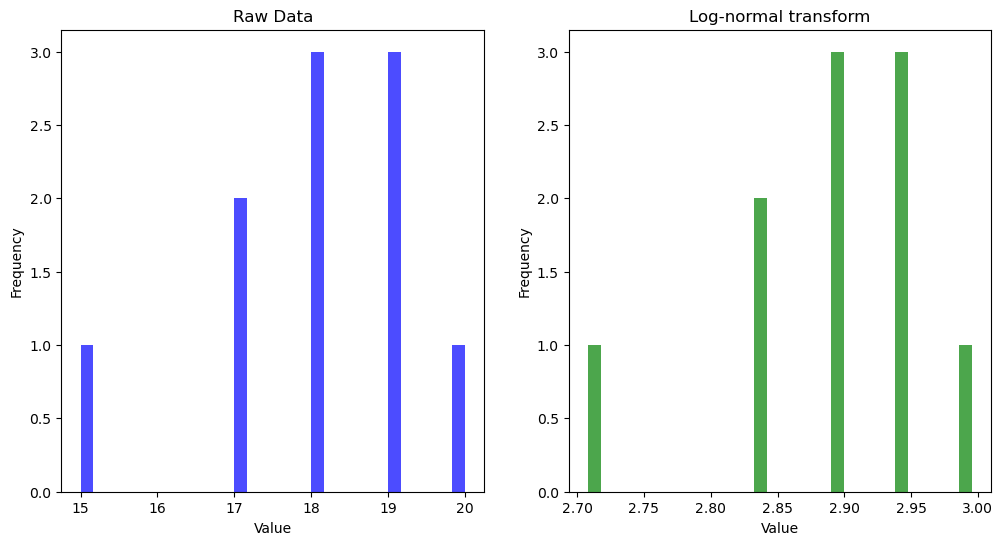

Shapiro-Wilk Test Statistic: 0.9045871439626347
P-value: 0.24583927527046656
The data is normally distributed (p = 0.246)
########### Levene Time ################
Levene's test statistic: 0.0
P-value: 1.0
Levene's test statistic: 0.31034482758620674
P-value: 0.584329990665335
Levene's test statistic: 0.26470588235294107
P-value: 0.613164852382936


In [26]:


def test_assumptions(dataset):
    for regionYear in regionYears:
        print('-------------------', regionYear, '------------------------')
        for type in range(3):
            print(regionYear, type)
            rawdata = dataset[regionYear][type]
            fig, axes = plt.subplots(1, 2, figsize=(12, 6))

            # Plot the first histogram (normal distribution)
            axes[0].hist(rawdata, bins=30, color='blue', alpha=0.7)
            axes[0].set_title('Raw Data')
            axes[0].set_xlabel('Value')
            axes[0].set_ylabel('Frequency')
            print('before: ', rawdata)
            data = np.log(rawdata)
            print('after: ', data)
            # Plot the second histogram (log-normal distribution)
            axes[1].hist(data, bins=30, color='green', alpha=0.7)
            axes[1].set_title('Log-normal transform')
            axes[1].set_xlabel('Value')
            axes[1].set_ylabel('Frequency')
            plt.show()
            plt.close()
            # Perform the Shapiro-Wilk test
            statistic, p_value = stats.shapiro(data)
            
            # Print results
            print(f"Shapiro-Wilk Test Statistic: {statistic}")
            print(f"P-value: {p_value}")
        
            # Interpret the result
            if p_value > 0.05:
                print(f"The data is normally distributed (p = {p_value:.3f})")
            else:
                print('NOT NORMAL----------------------------------------')
                print(f"The data is not normally distributed (p = {p_value:.3f})")
        print('###########', 'Levene Time', '################')
        for combo in [[0, 1], [0, 2], [1, 2]]:
            
            # Perform Levene's test for homogeneity of variances
            stat, p_value = stats.levene(dataset[regionYear][combo[0]] , dataset[regionYear][combo[1]])
            # Print the test statistic and p-value
            print(f"Levene's test statistic: {stat}")
            print(f"P-value: {p_value}")
test_assumptions(box_plot_data)

In [73]:
# Friedman and posthoc wilcoxon for the indices
from scipy.stats import friedmanchisquare, wilcoxon
from itertools import combinations
def friedman_and_posthoc(datasets, name):
    print('------------------------')
    print(name)
    for regionYear in regionYears:
        print('-------------', regionYear, '-------------------')
        # Example data (related groups)
        list1 = datasets[regionYear][0]
        list2 = datasets[regionYear][1]
        list3 = datasets[regionYear][2]
        
        # Step 1: Perform Friedman Test
        stat, p = friedmanchisquare(list1, list2, list3)
        print(f"Friedman Test: Chi-square statistic = {stat}, p-value = {p}")
        
        if p < 0.05:
            print("Significant differences found. Proceeding with pairwise comparisons.")
            
            # Step 2: Perform pairwise Wilcoxon Signed-Rank Tests
            data = [list1, list2, list3]
            labels = ['CI', 'HI', 'HM']
            comparisons = combinations(range(len(data)), 2)  # Generate pairwise indices
            
            for i, j in comparisons:
                print(data[i], data[j])
                print(f"Mean of {labels[i]}: {np.mean(data[i])}, Mean of {labels[j]}: {np.mean(data[j])}")
                stat, p = wilcoxon(data[i], data[j])
                print(f"Wilcoxon Test ({labels[i]} vs {labels[j]}): Statistic = {stat}, p-value = {p}")
        else:
            print("No significant differences found. No need for pairwise comparisons.")
friedman_and_posthoc(box_plot_data, 'RICHNESS')
friedman_and_posthoc(shannon_box_data, 'SHANNON')
friedman_and_posthoc(pielou_box_data, 'PIELOU')

------------------------
RICHNESS
------------- Gulf -------------------
Friedman Test: Chi-square statistic = 14.599999999999994, p-value = 0.0006755387751938461
Significant differences found. Proceeding with pairwise comparisons.
[24, 23, 24, 21, 19, 21, 18, 17, 22, 19] [27, 26, 26, 26, 23, 24, 23, 23, 27, 23]
Mean of CI: 20.8, Mean of HI: 24.8
Wilcoxon Test (CI vs HI): Statistic = 0.0, p-value = 0.001953125
[24, 23, 24, 21, 19, 21, 18, 17, 22, 19] [23, 15, 27, 13, 13, 12, 8, 9, 19, 12]
Mean of CI: 20.8, Mean of HM: 15.1
Wilcoxon Test (CI vs HM): Statistic = 2.5, p-value = 0.009765625
[27, 26, 26, 26, 23, 24, 23, 23, 27, 23] [23, 15, 27, 13, 13, 12, 8, 9, 19, 12]
Mean of HI: 24.8, Mean of HM: 15.1
Wilcoxon Test (HI vs HM): Statistic = 1.0, p-value = 0.00390625
------------- Pacific -------------------
Friedman Test: Chi-square statistic = 2.388888888888895, p-value = 0.30287216976780157
No significant differences found. No need for pairwise comparisons.
------------- NL 2020 --------

In [68]:
regional_richness

{'Gulf': [29, 32, 21, 26],
 'Pacific': [25, 29, 37],
 'NL 2020': [24, 27, 16],
 'NL 2021': [24, 27, 25]}

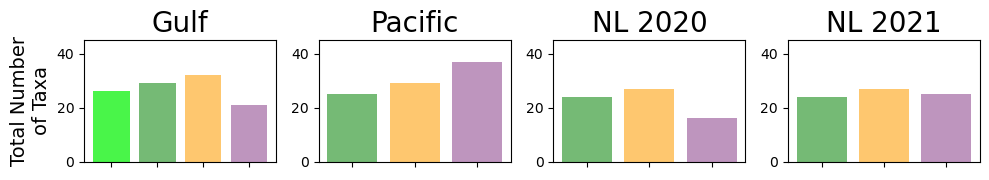

In [70]:
#small bar graphs for total species richness in all ten samples for each sorting process and regionYear
fig, axes = plt.subplots(1, 4, figsize=(10, 2))

# Loop through each regionYear and corresponding subplot
for i, regionYear in enumerate(regionYears):
    ax = axes[i]  # Access the correct subplot
    if i == 0:
        colors = ['#49f549', '#75ba75', '#fec76f', '#be95be']
        thisRichness = regional_richness[regionYear]
        thisRichness = [thisRichness[3]] + thisRichness[:3]
        ax.bar([1, 2, 3, 4], thisRichness, color=colors)
        ax.set_xticks([1, 2, 3, 4], [])
    # Create the bar plot in the current subplot
    else:
        colors = ['#75ba75', '#fec76f', '#be95be']
        ax.bar([1, 2, 3], regional_richness[regionYear], color=colors)
        ax.set_xticks(np.array(range(len(types))) + 1, ['' for type in types])
    ax.set_title(regionYear, fontsize=20)  # Set the title for the subplot
    # ax.set_xlabel("Classification Method")  # Example x-axis label
    
    
    ax.set_ylim([0, 45])
# Adjust layout to avoid overlap
axes[0].set_ylabel("Total Number\nof Taxa", fontsize=14)    # Example y-axis label
# fig.text(0.5, 0, "Sorting Process", ha='center', va='center', fontsize=14)
# fig.text(0.04, .9, f"(a)", ha='right', va='center', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.suptitle("Number of Taxa Identified by Region and Method", fontsize=14)
# Show the plot
plt.show()

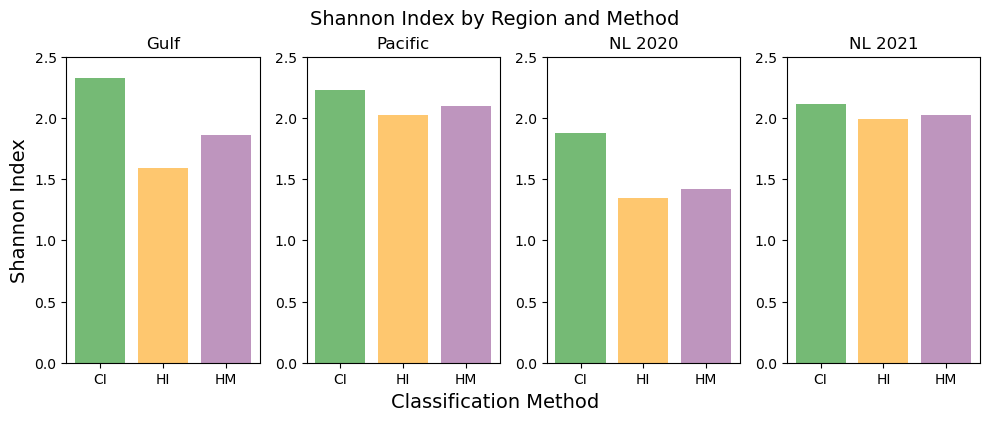

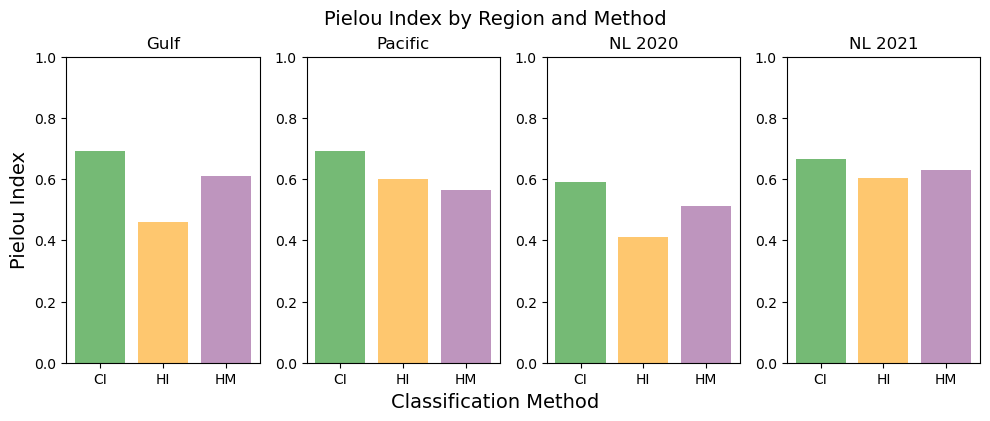

In [20]:
#bar graphs for average pielou and shannon across all ten samples for each sorting process and regionYear
def regional_bars(title, ylabel, data_dict, ylim):
    # Create a 2x2 grid of subplots
    fig, axes = plt.subplots(1, 4, figsize=(10, 4))
    colors = ['#75ba75', '#fec76f', '#be95be']
    # Loop through each regionYear and corresponding subplot
    for i, regionYear in enumerate(regionYears):
        ax = axes[i]  # Access the correct subplot
    
        # Create the bar plot in the current subplot
        ax.bar([1, 2, 3], data_dict[regionYear], color=colors)
        ax.set_title(regionYear)  # Set the title for the subplot
        # ax.set_xlabel("Classification Method")  # Example x-axis label
        
        ax.set_xticks(np.array(range(len(types))) + 1, types)
        ax.set_ylim(ylim)
    # Adjust layout to avoid overlap
    axes[0].set_ylabel(ylabel, fontsize=14)    # Example y-axis label
    fig.text(0.5, 0, "Classification Method", ha='center', va='center', fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.suptitle(title, fontsize=14)
    # Show the plot
    plt.show()

regional_bars("Shannon Index by Region and Method", "Shannon Index", shannons, [0, 2.5])
regional_bars("Pielou Index by Region and Method", "Pielou Index", pielous, [0, 1])

In [21]:
#calculate simper and mean dissimilarity for each regionyear and each sample, between the three sorting processes. 
simper_results = {}
mean_disses = {}
for regionYear in regionYears:
    print('-------------------', regionYear, '----------------------------------------------------------------')
    mean_disses[regionYear] = []
    sampleNames = relabund_df[relabund_df['regionYear'] == regionYear]['FlowCamID'].unique()
    simper_results[regionYear] = []
    for sampleName in sampleNames:
        print('--------###--------', sampleName, '---------###--------')
        type_dfs = []
        data_df = pd.DataFrame()
        relabunds = []
        # print(types)
        for t, type in enumerate(types):
            test_df = relabund_df[(relabund_df['regionYear'] == regionYear) & (relabund_df['FlowCamID'] == sampleName)]
            test_df = test_df[test_df['type'] == type]
            data = test_df.groupby("newName")["relabund"].apply(np.mean).reset_index()
            data['type'] = type
            newNames = data['newName'].to_numpy()
            if t == 0:
                data_df['newName'] = newNames
            data_df[type] = data['relabund'].to_numpy()
            relabunds.append(data['relabund'].to_numpy())
        # print("relabunds: ", relabunds)
        pivoted = pd.DataFrame(relabunds, columns=newNames)
        # print("pivoted: ", pivoted)
        
        # print("types: ", types)
        result = simper(pivoted, types, metric='braycurtis', top_n=50)
        typeDisses = []
        result['combo'] = result['Group1'] + ' vs ' + result['Group2']
        for combo in result['combo'].unique():
            typeDisses.append(result[result['combo'] == combo]['Dissimilarity (%)'].mean())
        sampleMeanDiss = typeDisses
        mean_disses[regionYear].append(sampleMeanDiss)
        # print("Mean Dissim: ", result['Dissimilarity (%)'].mean())
        simper_results[regionYear].append(result)

------------------- Gulf ----------------------------------------------------------------
--------###-------- AMMP_Gulf_StPeters_1_20200903HT_250UM ---------###--------
--------###-------- AMMP_Gulf_StPeters_1_20200903LT_250UM ---------###--------
--------###-------- AMMP_Gulf_StPeters_1_20200904HT_250UM ---------###--------
--------###-------- AMMP_Gulf_StPeters_2B_20200903_250UM ---------###--------
--------###-------- AMMP_Gulf_StPeters_2_20200903HT_250UM ---------###--------
--------###-------- AMMP_Gulf_StPeters_2_20200904HT_250UM ---------###--------
--------###-------- AMMP_Gulf_StPeters_3B_20200903_250UM ---------###--------
--------###-------- AMMP_Gulf_StPeters_3_20200903HT_250UM ---------###--------
--------###-------- AMMP_Gulf_StPeters_3_20200903LT_250UM ---------###--------
--------###-------- AMMP_Gulf_StPeters_3_20200904HT_250UM ---------###--------
------------------- Pacific ----------------------------------------------------------------
--------###-------- AMMP_PA_S

In [22]:
#showing mean dissimilarity for the three comparison of sorting processes in each regionYear
for regionYear in regionYears:
    print(np.mean(mean_disses[regionYear], axis=0))

[0.36903363 0.39670175 0.36328018]
[0.14988029 0.20794592 0.15140675]
[0.26513039 0.27296766 0.07089738]
[0.16968969 0.20397821 0.11637793]


In [23]:
#showing global mean dissimilarity in each regionYear
for regionYear in regionYears:
    print(np.mean(mean_disses[regionYear]))

0.37633852239965676
0.16974431821574895
0.20299847605182023
0.16334861129582373


In [24]:
mean_simper_results

NameError: name 'mean_simper_results' is not defined

In [29]:
#depecreated code for simper graphs. Needs to either trim dfs so they only include most abundant taxa, or insert taxa as 0% where they do not appear across all samples
mean_simper_results = {}

for regionYear in regionYears:
    print(regionYear)
    dfs = simper_results[regionYear]
    conts = []
    for df in dfs:
        cont = list(df['Contribution (%)'])
        # print(len(cont))
        names = list(df['Species'])
        combo = df['Group1'] + ' vs ' + df['Group2']
        conts.append(cont)
        print(len(cont)/3)
    conts = np.array(conts)
    mean_conts = np.mean(conts, axis=0)
    print(len(names))
    print(len(mean_conts))
    mean_simper_results[regionYear] = pd.DataFrame().from_dict({'combo': combo, 'Species': names, 'contribution': mean_conts})
    
mean_simper_results[regionYear]['contribution'].to_numpy()

Gulf
31.0
27.0
31.0
26.0
23.0
24.0
23.0
23.0
28.0
24.0


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (10,) + inhomogeneous part.

In [30]:
#deprecated code, mean_simper_results does not exist unless fixed in the above cell -- see note there.
allNames = []
headers = []
for regionYear in regionYears:
    print('-----------', regionYear, '----------------------------------------------------------------')
    df = mean_simper_results[regionYear]
    combos = df['combo'].unique()
    for combo in combos:
        print('###############', combo, '##############')
        header = df[df['combo'] == combo].sort_values('contribution', ascending=False).head(5)
        header['regionYear'] = regionYear
        headers.append(header)
        names = list(header['Species'])
        allNames.append(names)
        print(header)
        print('-----------------')
flatNames = np.array(allNames).flatten()
print(flatNames)
print(np.unique(flatNames))
print(len(np.unique(flatNames)))

----------- Gulf ----------------------------------------------------------------


KeyError: 'Gulf'

In [31]:
#deprecated code. see above.
headers = pd.concat(headers)
headers

ValueError: No objects to concatenate

In [32]:
# deprecated code...see above.
color_palette = {
    "Acartia spp." : "#66c2a5",  # Color for Taxon1
    "Bivalvia (larvae)" : "#fc8d62",  # Color for Taxon2
    "Calanoida (ci-ciii)" : "#8da0cb",  # Color for Taxon3
    "Copepoda (nauplii)" : "#e78ac3",  # Color for Taxon4
    "Oithona spp." : "#a6d854",  # Color for Taxon5
    "Podon/Pleopsis spp." : "#ffd92f",  # Color for Taxon6
    "Cirripedia (larvae)" : "#e5c494",  # Color for Taxon7
    "Oikopleura spp." : "#984ea3",  # Color for Taxon8
    "Evadne spp." : "#a6cee3",  # Color for Taxon9
    "Temora spp." : "#1f78b4", # Color for Taxon10
    "Pseudocalanus spp." : "#ff7f00", # Color for Taxon10
    "Pseudodiaptomus spp." : "#999999",    # Color for "Other"
    # "Eurytemora spp." : "black",
    "Paracalanus spp." : "olive",
    "Fritillaria spp." : "#8B0000",
    "Corycaeidae" : "green",
    
}
colorNames = list(color_palette.keys())
for flatName in flatNames:
    if flatName not in colorNames:
        print(flatName)


NameError: name 'flatNames' is not defined

TypeError: list indices must be integers or slices, not str

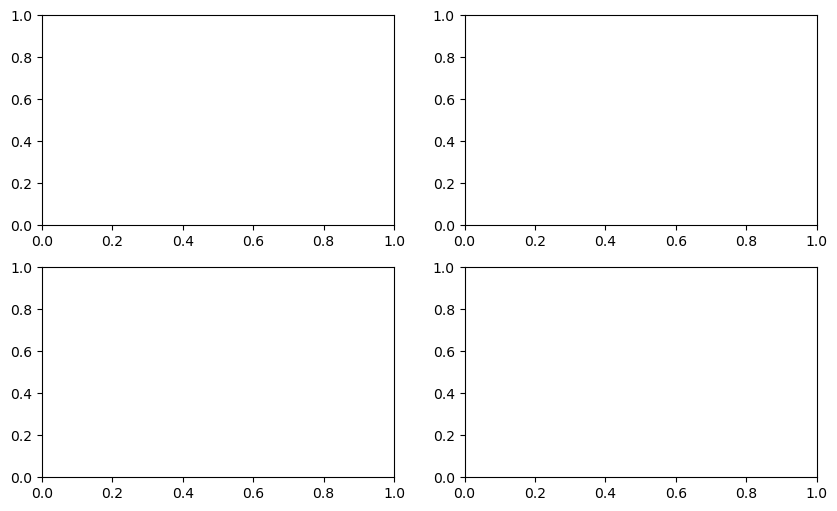

In [33]:
# displays bar graphs for simper analysis. deprecated. see above.
from matplotlib.lines import Line2D
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
# Bar width
width = 0.5

for r, regionYear in enumerate(regionYears):
    df = headers[headers['regionYear'] == regionYear]

    labels = df['combo'].unique()
    # Define the positions of the bars
    x = np.arange(len(labels))
    for l, label in enumerate(labels):
        contributions = df[df['combo'] == label]['contribution'].to_numpy()
        names = df[df['combo'] == label]['Species'].to_numpy()

        # Plotting the stacked bars
        row = r // 2  # Determine the row index
        col = r % 2   # Determine the column index
        ax = axes[row, col]  # Access the correct subplot
        bottom = 0
        # Stack the bars by adding them one after another
        for i, contribution in enumerate(contributions):
            ax.bar(l, contribution, width=width, label=names[i], color=color_palette[names[i]], bottom=bottom)
            bottom += contribution

    # Add labels and title
    ax.set_xlabel('Sorting Process Comparisons', fontsize=14)
    ax.set_ylabel('Contribution (%)', fontsize=14)
    ax.set_title(f'SIMPER Contributions (%) for {regionYear}')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylim([0, 105])

special_taxa = list(color_palette.keys())
colors = list(color_palette.values())
legend_elements = [
    Line2D([0], [0], marker='s', color='w', markerfacecolor=colors[0], markersize=10, label=special_taxa[0]),
    Line2D([0], [0], marker='s', color='w', markerfacecolor=colors[1], markersize=10, label=special_taxa[1]),
    Line2D([0], [0], marker='s', color='w', markerfacecolor=colors[2], markersize=10, label=special_taxa[2]),
    Line2D([0], [0], marker='s', color='w', markerfacecolor=colors[3], markersize=10, label=special_taxa[3]),
    Line2D([0], [0], marker='s', color='w', markerfacecolor=colors[4], markersize=10, label=special_taxa[4]),
    Line2D([0], [0], marker='s', color='w', markerfacecolor=colors[5], markersize=10, label=special_taxa[5]),
    Line2D([0], [0], marker='s', color='w', markerfacecolor=colors[6], markersize=10, label=special_taxa[6]),
    Line2D([0], [0], marker='s', color='w', markerfacecolor=colors[7], markersize=10, label=special_taxa[7]),
    Line2D([0], [0], marker='s', color='w', markerfacecolor=colors[8], markersize=10, label=special_taxa[8]),
    Line2D([0], [0], marker='s', color='w', markerfacecolor=colors[9], markersize=10, label=special_taxa[9]),
    Line2D([0], [0], marker='s', color='w', markerfacecolor=colors[10], markersize=10, label=special_taxa[10]),
    Line2D([0], [0], marker='s', color='w', markerfacecolor=colors[11], markersize=10, label=special_taxa[11]),
    Line2D([0], [0], marker='s', color='w', markerfacecolor=colors[12], markersize=10, label=special_taxa[12]),
    Line2D([0], [0], marker='s', color='w', markerfacecolor=colors[13], markersize=10, label=special_taxa[13]),
    # Line2D([0], [0], marker='s', color='w', markerfacecolor=colors[14], markersize=10, label=special_taxa[14]),
]
# Display the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])
fig.legend(handles=legend_elements, loc='upper right', fontsize=14, title="Species", bbox_to_anchor=(1.31, .9))
plt.show()
plt.close()

In [ ]:
# shows simper results. deprecated. see above cells.
from matplotlib.lines import Line2D
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
for r, regionYear in enumerate(regionYears):
    simper_results[regionYear]['combo'] = simper_results[regionYear]['Group1'] + '+' + simper_results[regionYear]['Group2']
    df = simper_results[regionYear].copy()
    all_species = df['Species'].unique()
    for combo in df['combo'].unique():
        for species in all_species:
            if species in list(df[df['combo'] == combo]['Species'].to_numpy()):
                continue
            else:
                # New row data
                new_row = {'Group1': '', 'Group2': '', 'Species': species, 'Contribution (%)': 0, 'Cumulative (%)': 0, 'combo': combo}
                # Add the row using loc
                df.loc[len(df)] = new_row
    df = df.sort_values(by=['combo', 'Species'], ascending=[True, False]).reset_index(drop=True)
    
    
    
    # Example data: 3 groups, each with 6 contributions
    labels = ['CI vs HI', 'CI vs HM', 'HI vs HM']
    contributions = []
    unique_species = list(df['Species'].unique())
    print(unique_species)
    for species in unique_species:
        contributions.append(list(df[df['Species'] == species]['Contribution (%)'].to_numpy()))
    print(contributions)
    
    # Define the positions of the bars
    x = np.arange(len(labels))
    
    # Bar width
    width = 0.5
    
    # Plotting the stacked bars
    row = r // 2  # Determine the row index
    col = r % 2   # Determine the column index
    ax = axes[row, col]  # Access the correct subplot
    bottom = [0, 0, 0]
    bottom = np.array(bottom)
    # Stack the bars by adding them one after another
    for i, category in enumerate(contributions):
        ax.bar(x, contributions[i], width=width, label=unique_species[i], color=color_palette[unique_species[i]], bottom=bottom)
        bottom = bottom + np.array(contributions[i])

    # Add labels and title
    ax.set_xlabel('Sorting Process Comparisons', fontsize=14)
    ax.set_ylabel('Contribution (%)', fontsize=14)
    ax.set_title(f'SIMPER Contributions (%) for {regionYear}')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylim([0, 105])

special_taxa = list(color_palette.keys())
colors = list(color_palette.values())
legend_elements = [
    Line2D([0], [0], marker='s', color='w', markerfacecolor=colors[0], markersize=10, label=special_taxa[0]),
    Line2D([0], [0], marker='s', color='w', markerfacecolor=colors[1], markersize=10, label=special_taxa[1]),
    Line2D([0], [0], marker='s', color='w', markerfacecolor=colors[2], markersize=10, label=special_taxa[2]),
    Line2D([0], [0], marker='s', color='w', markerfacecolor=colors[3], markersize=10, label=special_taxa[3]),
    Line2D([0], [0], marker='s', color='w', markerfacecolor=colors[4], markersize=10, label=special_taxa[4]),
    Line2D([0], [0], marker='s', color='w', markerfacecolor=colors[5], markersize=10, label=special_taxa[5]),
    Line2D([0], [0], marker='s', color='w', markerfacecolor=colors[6], markersize=10, label=special_taxa[6]),
    Line2D([0], [0], marker='s', color='w', markerfacecolor=colors[7], markersize=10, label=special_taxa[7]),
    Line2D([0], [0], marker='s', color='w', markerfacecolor=colors[8], markersize=10, label=special_taxa[8]),
    Line2D([0], [0], marker='s', color='w', markerfacecolor=colors[9], markersize=10, label=special_taxa[9]),
    Line2D([0], [0], marker='s', color='w', markerfacecolor=colors[10], markersize=10, label=special_taxa[10]),
    Line2D([0], [0], marker='s', color='w', markerfacecolor=colors[11], markersize=10, label=special_taxa[11]),
    Line2D([0], [0], marker='s', color='w', markerfacecolor=colors[12], markersize=10, label=special_taxa[12]),
    Line2D([0], [0], marker='s', color='w', markerfacecolor=colors[13], markersize=10, label=special_taxa[13]),
    # Line2D([0], [0], marker='s', color='w', markerfacecolor=colors[14], markersize=10, label=special_taxa[14]),
]
# Display the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])
fig.legend(handles=legend_elements, loc='upper right', fontsize=14, title="Species", bbox_to_anchor=(1.31, .9))
plt.show()
plt.close()


In [ ]:
max_relabund_df

In [ ]:
relabund_df

In [34]:
#calculating friedman data for the upcoming graphs
from scipy import stats
stes = {}
p_bools = {}
frieds = {}
relabund_dict = {}
fried_newNames = {}
for regionYear in regionYears:
    stes[regionYear] = {}
    stes[regionYear]['CI'] = []
    stes[regionYear]['HI'] = []
    stes[regionYear]['HM'] = []
    p_bools[regionYear] = []
    frieds[regionYear] = []
    fried_newNames[regionYear] = []
    print('---------------', regionYear, '--------------')
    newNames = relabund_df[relabund_df['regionYear'] == regionYear]['newName'].unique()
    for newName in newNames:
        cirels = relabund_df[(relabund_df['newName'] == newName) & (relabund_df['regionYear'] == regionYear) & (relabund_df['type'] == 'CI')]['relabund'].to_numpy()
        hirels = relabund_df[(relabund_df['newName'] == newName) & (relabund_df['regionYear'] == regionYear) & (relabund_df['type'] == 'HI')]['relabund'].to_numpy()
        hmrels = relabund_df[(relabund_df['newName'] == newName) & (relabund_df['regionYear'] == regionYear) & (relabund_df['type'] == 'HM')]['relabund'].to_numpy()
        cise = np.std(cirels, ddof=1)/np.sqrt(len(cirels))
        hise = np.std(hirels, ddof=1)/np.sqrt(len(hirels))
        hmse = np.std(hmrels, ddof=1)/np.sqrt(len(hmrels))

        stes[regionYear]['CI'].append(cise)
        stes[regionYear]['HI'].append(hise)
        stes[regionYear]['HM'].append(hmse)
        # Apply the Friedman test (non-parametric test for repeated measures)
        stat, p_value = stats.friedmanchisquare(hmrels, hirels, cirels)
        
        p_bools[regionYear].append(1 if p_value < 0.05 else 0)
        frieds[regionYear].append(stat)
        fried_newNames[regionYear].append(newName)
        newdf = pd.DataFrame().from_dict({})

--------------- Gulf --------------
--------------- Pacific --------------
--------------- NL 2020 --------------
--------------- NL 2021 --------------


In [35]:
#Preparing data for the heatmaps in the upcoming graphs
qdfs = []
for regionYear in regionYears:
    qdf = pd.DataFrame().from_dict({'newName': fried_newNames[regionYear], 'Q': frieds[regionYear], 'p_bool': p_bools[regionYear]})
    qdf['regionYear'] = regionYear
    qdfs.append(qdf)
qdf = pd.concat(qdfs)
qdict = {}
pdict = {}
for regionYear in regionYears:
    qdict[regionYear] = {}
    pdict[regionYear] = {}
for i, row in qdf.iterrows():
    regionYear = row['regionYear']
    newName = row['newName']
    qdict[regionYear][newName] = row['Q']
    pdict[regionYear][newName] = row['p_bool']
for i, row in relabund_df.iterrows():
    regionYear = row['regionYear']
    newName = row['newName']
    type = row['type']
    relabund_df.loc[i, 'Q'] = qdict[regionYear][newName]
    relabund_df.loc[i, 'p_bool'] = pdict[regionYear][newName]
    mean_df = mean_richness_dict[regionYear][type]
    mean_relabund = mean_df[mean_df['newName'] == newName].iloc[0]['relabund']
    se_df = pd.DataFrame().from_dict({'newName': fried_newNames[regionYear], 'se': stes[regionYear][type]})
    se = se_df[se_df['newName'] == newName].iloc[0]['se']
    relabund_df.loc[i, 'mean relabund'] = mean_relabund
    relabund_df.loc[i, 'se'] = se
relabund_df.loc[:50]

,Unnamed: 0,newName,FlowCamID,regionYear,type,abund,sumabund,relabund,Q,p_bool,mean relabund,se
0,30,Acartia spp.,AMMP_Gulf_StPeters_1_20200903HT_250UM,Gulf,CI,52.000000,3847.000000,0.013517,18.2,1.0,0.228792,0.047604
1,33,Acartia spp.,AMMP_Gulf_StPeters_1_20200903LT_250UM,Gulf,CI,927.000000,3268.000000,0.283660,18.2,1.0,0.228792,0.047604
2,36,Acartia spp.,AMMP_Gulf_StPeters_1_20200904HT_250UM,Gulf,CI,99.000000,7495.000000,0.013209,18.2,1.0,0.228792,0.047604
3,39,Acartia spp.,AMMP_Gulf_StPeters_2B_20200903_250UM,Gulf,CI,1127.000000,2895.000000,0.389292,18.2,1.0,0.228792,0.047604
4,42,Acartia spp.,AMMP_Gulf_StPeters_2_20200903HT_250UM,Gulf,CI,1194.000000,4104.000000,0.290936,18.2,1.0,0.228792,0.047604
5,45,Acartia spp.,AMMP_Gulf_StPeters_2_20200904HT_250UM,Gulf,CI,1537.000000,4177.000000,0.367967,18.2,1.0,0.228792,0.047604
6,48,Acartia spp.,AMMP_Gulf_StPeters_3B_20200903_250UM,Gulf,CI,1204.000000,3322.000000,0.362432,18.2,1.0,0.228792,0.047604
7,51,Acartia spp.,AMMP_Gulf_StPeters_3_20200903HT_250UM,Gulf,CI,663.000000,3231.000000,0.205200,18.2,1.0,0.228792,0.047604
8,54,Acartia spp.,AMMP_Gulf_StPeters_3_20200903LT_250UM,Gulf,CI,167.000000,3594.000000,0.046466,18.2,1.0,0.228792,0.047604
9,57,Acartia spp.,AMMP_Gulf_StPeters_3_20200904HT_250UM,Gulf,CI,970.000000,3077.000000,0.315242,18.2,1.0,0.228792,0.047604


In [36]:
#calculating friedman data for the upcoming graphs for max gulf
from scipy import stats
max_stes = {}
max_p_bools = {}
max_frieds = {}
relabund_dict = {}
fried_newNames = {}
for regionYear in regionYears:
    max_stes[regionYear] = {}
    max_stes[regionYear]['CI'] = []
    max_stes[regionYear]['HI'] = []
    max_stes[regionYear]['HM'] = []
    max_p_bools[regionYear] = []
    max_frieds[regionYear] = []
    fried_newNames[regionYear] = []
    print('---------------', regionYear, '--------------')
    newNames = max_relabund_df[max_relabund_df['regionYear'] == regionYear]['newName'].unique()
    for newName in newNames:
        cirels = max_relabund_df[(max_relabund_df['newName'] == newName) & (max_relabund_df['regionYear'] == regionYear) & (max_relabund_df['type'] == 'CI')]['relabund'].to_numpy()
        hirels = max_relabund_df[(max_relabund_df['newName'] == newName) & (max_relabund_df['regionYear'] == regionYear) & (max_relabund_df['type'] == 'HI')]['relabund'].to_numpy()
        hmrels = max_relabund_df[(max_relabund_df['newName'] == newName) & (max_relabund_df['regionYear'] == regionYear) & (max_relabund_df['type'] == 'HM')]['relabund'].to_numpy()
        cise = np.std(cirels, ddof=1)/np.sqrt(len(cirels))
        hise = np.std(hirels, ddof=1)/np.sqrt(len(hirels))
        hmse = np.std(hmrels, ddof=1)/np.sqrt(len(hmrels))

        max_stes[regionYear]['CI'].append(cise)
        max_stes[regionYear]['HI'].append(hise)
        max_stes[regionYear]['HM'].append(hmse)
        # Apply the Friedman test (non-parametric test for repeated measures)
        stat, p_value = stats.friedmanchisquare(hmrels, hirels, cirels)
        
        max_p_bools[regionYear].append(1 if p_value < 0.05 else 0)
        max_frieds[regionYear].append(stat)
        fried_newNames[regionYear].append(newName)
        newdf = pd.DataFrame().from_dict({})

--------------- Gulf --------------


C:\Users\newblearbomb\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:9377: RuntimeWarning: invalid value encountered in scalar divide
  chisq = (12.0 / (k*n*(k+1)) * ssbn - 3*n*(k+1)) / c


--------------- Pacific --------------
--------------- NL 2020 --------------
--------------- NL 2021 --------------


In [37]:
#Preparing data for the heatmaps in the upcoming graphs for max_relabund_df
max_qdfs = []
for regionYear in regionYears:
    max_qdf = pd.DataFrame().from_dict({'newName': fried_newNames[regionYear], 'Q': frieds[regionYear], 'p_bool': p_bools[regionYear]})
    max_qdf['regionYear'] = regionYear
    max_qdfs.append(max_qdf)
max_qdf = pd.concat(max_qdfs)
max_qdict = {}
max_pdict = {}
for regionYear in regionYears:
    max_qdict[regionYear] = {}
    max_pdict[regionYear] = {}
for i, row in max_qdf.iterrows():
    regionYear = row['regionYear']
    newName = row['newName']
    max_qdict[regionYear][newName] = row['Q']
    max_pdict[regionYear][newName] = row['p_bool']
for i, row in max_relabund_df.iterrows():
    regionYear = row['regionYear']
    newName = row['newName']
    type = row['type']
    max_relabund_df.loc[i, 'Q'] = max_qdict[regionYear][newName]
    max_relabund_df.loc[i, 'p_bool'] = max_pdict[regionYear][newName]
    mean_df = max_mean_richness_dict[regionYear][type]
    mean_relabund = mean_df[mean_df['newName'] == newName].iloc[0]['relabund']
    se_df = pd.DataFrame().from_dict({'newName': fried_newNames[regionYear], 'se': max_stes[regionYear][type]})
    se = se_df[se_df['newName'] == newName].iloc[0]['se']
    max_relabund_df.loc[i, 'mean relabund'] = mean_relabund
    max_relabund_df.loc[i, 'se'] = se
max_relabund_df.loc[:50]

,Unnamed: 0,newName,FlowCamID,regionYear,type,abund,sumabund,relabund,Q,p_bool,mean relabund,se
0,30,Acartia spp.,AMMP_Gulf_StPeters_1_20200903HT_250UM,Gulf,CI,263.000000,3847.000000,0.068365,18.2,1.0,0.400733,0.074641
1,33,Acartia spp.,AMMP_Gulf_StPeters_1_20200903LT_250UM,Gulf,CI,1571.000000,3268.000000,0.480722,18.2,1.0,0.400733,0.074641
2,36,Acartia spp.,AMMP_Gulf_StPeters_1_20200904HT_250UM,Gulf,CI,267.000000,7495.000000,0.035624,18.2,1.0,0.400733,0.074641
3,39,Acartia spp.,AMMP_Gulf_StPeters_2B_20200903_250UM,Gulf,CI,1910.000000,2895.000000,0.659758,18.2,1.0,0.400733,0.074641
4,42,Acartia spp.,AMMP_Gulf_StPeters_2_20200903HT_250UM,Gulf,CI,1994.000000,4104.000000,0.485867,18.2,1.0,0.400733,0.074641
5,45,Acartia spp.,AMMP_Gulf_StPeters_2_20200904HT_250UM,Gulf,CI,2434.000000,4177.000000,0.582715,18.2,1.0,0.400733,0.074641
6,48,Acartia spp.,AMMP_Gulf_StPeters_3B_20200903_250UM,Gulf,CI,1979.000000,3322.000000,0.595725,18.2,1.0,0.400733,0.074641
7,51,Acartia spp.,AMMP_Gulf_StPeters_3_20200903HT_250UM,Gulf,CI,1398.000000,3231.000000,0.432683,18.2,1.0,0.400733,0.074641
8,54,Acartia spp.,AMMP_Gulf_StPeters_3_20200903LT_250UM,Gulf,CI,411.000000,3594.000000,0.114357,18.2,1.0,0.400733,0.074641
9,57,Acartia spp.,AMMP_Gulf_StPeters_3_20200904HT_250UM,Gulf,CI,1697.000000,3077.000000,0.551511,18.2,1.0,0.400733,0.074641


In [38]:
#THESE ARE ORDERED LISTS OF TAXA FOR THE PHYLOGENETIC TREES GENERATED IN R

# Gulf Ind Bar Graphs
order_from_r = [
    'Temora spp.',
    'Eurytemora spp.',
    'Calanoida (ci-ciii)',
    'Acartia spp.',
    'Calanus spp.',
    'Centropages spp.',
    'Labidocera spp.',
    'Paracalanus spp.',
    'Pseudocalanus spp.',
    'Pseudodiaptomus spp.',
    'Tortanus spp.',
    'Microsetella spp.',
    'Harpacticoida- epibenthic',
    'Monstrillidae',
    'Oithona spp.',
    'Copepoda (nauplii)',
    'Decapoda- non-brachyura (larvae)',
    'Decapoda- brachyura (larvae)',
    'Cirripedia (larvae)',
    'Podon/Pleopsis spp.',
    'Evadne spp.',
    'Ostracoda',
    'Oikopleura spp.',
    'Fritillaria spp.',
    'Ascidiacea (larvae)',
    'Osteichthyes (larvae)',
    'Obelia spp. (medusa)',
    'Hydrozoa (medusa)',
    'Cnidaria (larvae)',
    'Gastropoda (larvae/Limacina)',
    'Bivalvia (larvae)',
    'Bryozoa (larvae)',
    'Chaetognatha',
    'Echinodermata (larvae)',
    'Polychaeta (larvae)',
]


In [85]:
# Pacific Ind Bar Graphs
order_from_r = [
    'Calanoida (ci-ciii)',
    'Acartia spp.',
    'Calanus spp.',
    'Centropages spp.',
    'Epilabidocera spp.',
    'Paracalanus spp.',
    'Pseudocalanus spp.',
    'Tortanus spp.',
    'Oithona spp.',
    'Corycaeidae',
    'Harpacticoida- epibenthic',
    'Copepoda (nauplii)',
    'Decapoda- non-brachyura (larvae)',
    'Decapoda- brachyura (larvae)',
    'Isopoda (larvae)',
    'Amphipoda- epibenthic',
    'Cirripedia (larvae)',
    'Podon/Pleopsis spp.',
    'Evadne spp.',
    'Ostracoda',
    'Neoturris spp. (medusa)',
    'Leuckartiara spp. (medusa)',
    'Euphysa spp. (medusa)',
    'Sarsia spp. (medusa)',
    'Siphonophorae (nectophore)',
    'Calycophorae (nectophore)',
    'Obelia spp. (medusa)',
    'Hydrozoa (medusa)',
    'Scyphozoa (medusa)',
    'Scyphozoa (larvae)',
    'Oikopleura spp.',
    'Fritillaria spp.',
    'Ascidiacea (larvae)',
    'Osteichthyes (larvae)',
    'Polychaeta (larvae)',
    'Alciopidae sp.',
    'Gastropoda (larvae/Limacina)',
    'Bivalvia (larvae)',
    'Ctenophora (juvenile/adult)',
    'Ctenophora larvae',
    'Bryozoa (larvae)',
    'Chaetognatha',
    'Echinodermata (larvae)',
    'Platyhelminthes/Nemertea (juvenile)',
    'Platyhelminthes/Nemertea (larvae)',
]

In [83]:
#NL 2020 ind bar graphs
order_from_r = [
    'Temora spp.',
    'Eurytemora spp.',
    'Pseudocalanus spp.',
    'Microcalanus spp.',
    'Calanoida (ci-ciii)',
    'Acartia spp.',
    'Calanus spp.',
    'Centropages spp.',
    'Chiridius spp.',
    'Metridia spp.',
    'Oithona spp.',
    'Harpacticoida- epibenthic',
    'Copepoda (nauplii)',
    'Euphausiacea (larvae)',
    'Euphausiacea (nauplii)',
    'Decapoda- non-brachyura (larvae)',
    'Amphipoda',
    'Cirripedia (larvae)',
    'Podon/Pleopsis spp.',
    'Evadne spp.',
    'Obelia spp. (medusa)',
    'Anthoathecata (medusa)',
    'Aglantha spp. (medusa)',
    'Hydrozoa (medusa)',
    'Cnidaria (larvae)',
    'Gastropoda (larvae/Limacina)',
    'Bivalvia (larvae)',
    'Oikopleura spp.',
    'Fritillaria spp.',
    'Tomopteris spp.',
    'Polychaeta (larvae)',
    'Bryozoa (larvae)',
    'Chaetognatha',
    'Echinodermata (larvae)',
]

In [77]:
# NL 2021 ind bar graphs
order_from_r = [
    'Temora spp.',
    'Eurytemora spp.',
    'Pseudocalanus spp.',
    'Microcalanus spp.',
    'Calanoida (ci-ciii)',
    'Acartia spp.',
    'Calanus spp.',
    'Centropages spp.',
    'Tortanus spp.',
    'Monstrillidae',
    'Harpacticoida- epibenthic',
    'Oithona spp.',
    'Copepoda (nauplii)',
    'Euphausiacea (larvae)',
    'Euphausiacea (nauplii)',
    'Decapoda- non-brachyura (larvae)',
    'Cirripedia (larvae)',
    'Podon/Pleopsis spp.',
    'Evadne spp.',
    'Ostracoda',
    'Sarsia spp. (medusa)',
    'Obelia spp. (medusa)',
    'Hydrozoa (medusa)',
    'Aglantha spp. (medusa)',
    'Gastropoda (larvae/Limacina)',
    'Bivalvia (larvae)',
    'Oikopleura spp.',
    'Fritillaria spp.',
    'Bryozoa (larvae)',
    'Chaetognatha',
    'Echinodermata (larvae)',
    'Polychaeta (larvae)',
    'Foraminifera',
]

In [40]:
#add max gulf to relabund_df
max_gulf = max_relabund_df[max_relabund_df['regionYear'] == 'Gulf'].copy()
max_gulf = max_gulf.replace({'CI': 'CI-u'})
max_gulf = max_gulf[max_gulf['type'] == 'CI-u']
relabund_df = pd.concat([relabund_df, max_gulf])
relabund_df['type'].unique()
relabund_df[relabund_df['type'] == 'CI-u']

,Unnamed: 0,newName,FlowCamID,regionYear,type,abund,sumabund,relabund,Q,p_bool,mean relabund,se


In [70]:
df = relabund_df
df = df[df['regionYear'] =='Pacific']
# df = df[df['newName'] == 'Calanoida (ci-ciii)']
df = df[df['type'] == 'CI']
df

,Unnamed: 0,newName,FlowCamID,regionYear,type,abund,sumabund,relabund,Q,p_bool,mean relabund,se
90,90,Acartia spp.,AMMP_PA_S04W01_20210609HT_250um,Pacific,CI,249.0,1101.0,0.226158,12.600000,1.0,0.203420,0.013395
91,93,Acartia spp.,AMMP_PA_S04W01_20210609LT_250um,Pacific,CI,162.0,953.0,0.169990,12.600000,1.0,0.203420,0.013395
92,96,Acartia spp.,AMMP_PA_S04W01_20210610HT_250um,Pacific,CI,221.0,1098.0,0.201275,12.600000,1.0,0.203420,0.013395
93,99,Acartia spp.,AMMP_PA_S04W01_20210610LT_250um,Pacific,CI,200.0,997.0,0.200602,12.600000,1.0,0.203420,0.013395
94,102,Acartia spp.,AMMP_PA_S04W15_20210609HT_250um,Pacific,CI,221.0,915.0,0.241530,12.600000,1.0,0.203420,0.013395
...,...,...,...,...,...,...,...,...,...,...,...,...
4385,4395,Tortanus spp.,AMMP_PA_S04W15_20210609LT_250um,Pacific,CI,3.0,958.0,0.003132,0.358974,0.0,0.002928,0.000427
4386,4398,Tortanus spp.,AMMP_PA_S04W15_20210610LT_250um,Pacific,CI,3.0,1009.0,0.002973,0.358974,0.0,0.002928,0.000427
4387,4401,Tortanus spp.,AMMP_PA_S04W20_20210609HT_250um,Pacific,CI,3.0,950.0,0.003158,0.358974,0.0,0.002928,0.000427
4388,4404,Tortanus spp.,AMMP_PA_S04W20_20210609LT_250um,Pacific,CI,3.0,1009.0,0.002973,0.358974,0.0,0.002928,0.000427


keys:  ['CI' 'HI' 'HM' 'Mx']
list1 and transformed list1:  [0.009610844913287755, 0.20342038621341957, 0.0, 0.004083253523168016, 0.0, 0.046434218203921476, 0.002437951046893409, 0.002927764770182843, 0.0015233200037736059, 0.042703741235202194, 0.0, 0.005434365410585548, 0.004174465994862502, 0.010966549974607467, 0.0, 0.0, 0.2667150792289148, 0.09104998858999183, 0.04578755223607719, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.014337878011287108, 0.0, 0.011731496930150121, 0.0, 0.0, 0.17121938503347928, 0.02443627170094126, 0.0015654387240142636, 0.0, 0.006561152260379127, 0.0, 0.0059078193151207055, 0.009611731114942953, 0.0, 0.0, 0.00103416824829925, 0.0, 0.011108702368776474, 0.0, 0.005216474947721296] [0.21261171455264394, 0.5881184782674582, 0.0, 0.15983385778908382, 0.0, 0.3594286673243522, 0.13458861592294324, 0.1430579706960396, 0.1150615928096369, 0.34953336790209166, 0.0, 0.17581244451290384, 0.16101523710146484, 0.22217234928469132, 0.0, 0.0, 0.6436985388925895, 0.44987649053198553, 0

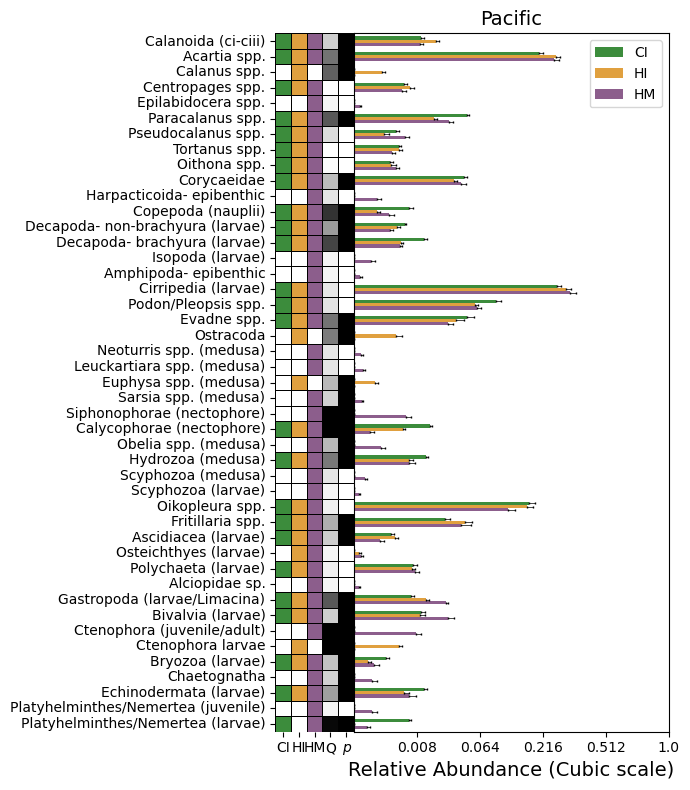

In [88]:
# function for creating individual taxa bar plots, showing which taxa had differences between sorting processes across the ten samples
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap

for r, regionYear in enumerate(regionYears):
    if regionYear != 'Pacific':
        continue
    # Data for the plot
    type_colors = ['#3c8c3c', '#e0a03f', '#8c5e8c', '#6dbf6d']
    
    # Simulated data (assuming `mean_richness_dict` exists in your context)
    keys = relabund_df['type'].unique()
    print('keys: ', keys)
    region_df = relabund_df[relabund_df['regionYear'] == regionYear].groupby(['newName', 'type']).agg({'Q': 'mean', 'mean relabund': 'mean', 'se': 'mean', 'p_bool': 'mean'}).reset_index()
    region_df = region_df.sort_values(['Q', 'newName'], ascending=[False, False]).reset_index(drop=True)

    region_df['newName'] = pd.Categorical(region_df['newName'], categories=order_from_r, ordered=True)
    #Sort the DataFrame by 'Taxa' column
    region_df = region_df.sort_values('newName')
    # print(region_df)

    list1 = list(region_df[region_df['type'] == keys[0]]['mean relabund'])
    list2 = list(region_df[region_df['type'] == keys[1]]['mean relabund'])
    list3 = list(region_df[region_df['type'] == keys[2]]['mean relabund'])
    def cube_transform(list1):
        arr1 = np.array(list1)
        logged = np.cbrt(arr1)
        return list(logged)

    transformed_list1 = cube_transform(list1)
    transformed_list2 = cube_transform(list2)
    transformed_list3 = cube_transform(list3)
    newNames = list(region_df[region_df['type'] == keys[0]]['newName'])
    # Number of categories (groups of bars)
    n = len(transformed_list1)
    
    print("list1 and transformed list1: ", list1, transformed_list1)
    # X-axis positions for the bars (grouped in threes)
    ind = np.arange(n)
    
    # Width of each bar
    width = 0.2
    figheight = 8
    if r == 1:
        figheight = 8
    # Create figure with subplots for bars and heatmap
    fig, (ax_heatmap_1, ax_heatmap_2, ax_heatmap_3, ax_frieds, ax_ps, ax) = plt.subplots(1, 6, figsize=(7, figheight), gridspec_kw={'width_ratios': [1, 1, 1, 1, 1, 20]})
    # Create bars for each transformed_list on the first axis (ax)

    ax.barh(ind - width, transformed_list1, width, label=keys[0], color=type_colors[0])
    asymmetric_errors = np.array([np.zeros_like(region_df[region_df['type'] == keys[0]]['se'].to_numpy()), region_df[region_df['type'] == keys[0]]['se'].to_numpy()])
    print('errors before transform: ', asymmetric_errors)
    total_cubed_errors = np.cbrt(np.array(list1) + asymmetric_errors[1])
    print("total cubed errors: ", total_cubed_errors)
    cubed_diffs = total_cubed_errors - np.array(transformed_list1)
    asymmetric_errors[1] = cubed_diffs
    print('errors: ', asymmetric_errors)
    ax.errorbar(transformed_list1, ind - width * 1.15, xerr=asymmetric_errors, capsize=1, ecolor='black', 
            elinewidth=.5, linestyle='none')
    
    ax.barh(ind, transformed_list2, width, label=keys[1], color=type_colors[1])
    asymmetric_errors = np.array([np.zeros_like(region_df[region_df['type'] == keys[1]]['se'].to_numpy()), region_df[region_df['type'] == keys[1]]['se'].to_numpy()])
    total_cubed_errors = np.cbrt(np.array(list2) + asymmetric_errors[1])
    cubed_diffs = total_cubed_errors - np.array(transformed_list2)
    asymmetric_errors[1] = cubed_diffs
    ax.errorbar(transformed_list2, ind, xerr=asymmetric_errors, capsize=1, ecolor='black', 
            elinewidth=.5, linestyle='none')
    
    ax.barh(ind + width, transformed_list3, width, label=keys[2], color=type_colors[2])
    asymmetric_errors = np.array([np.zeros_like(region_df[region_df['type'] == keys[2]]['se'].to_numpy()), region_df[region_df['type'] == keys[2]]['se'].to_numpy()])
    total_cubed_errors = np.cbrt(np.array(list3) + asymmetric_errors[1])
    cubed_diffs = total_cubed_errors - np.array(transformed_list3)
    asymmetric_errors[1] = cubed_diffs
    ax.errorbar(transformed_list3, ind + width * 1, xerr=asymmetric_errors, capsize=1, ecolor='black', 
            elinewidth=.5, linestyle='none')
    
    # Labeling the graph
    # ax.set_xlabel('Relative Abundance (' + r'$\sqrt[3]{scale}$' +')', fontsize=14)
    ax.set_xlabel('Relative Abundance (Cubic scale)', fontsize=14)
    ax.set_ylabel('')
    ax.set_title(regionYear, fontsize=14)
    ax.set_yticks(ind)
    xtick_locations = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax.set_xticks(xtick_locations, np.round(xtick_locations**3, 3))
    ax.set_yticklabels(['' for newName in newNames])
    ax.set_ylim(ind[-1] + width*2.5, ind[0] - width*2.5)
    # Adding a legend
    # ax.set_xlim([0, 0.01])
    ax.legend()
    ticks = ax.get_xticks()  # Get the current xticks
    ax.set_xticks(ticks[1:])  # Set xticks to exclude the first one
    ax.set_yticks([])
    
    # Create heatmap on the second axis (ax_heatmap)
    # Here, we're just using the 'transformed_list1', 'transformed_list2', and 'transformed_list3' values as heatmap intensity data.
    # You can adjust this to reflect any data you wish.
    colors1 = ['white', type_colors[0]]
    colors2 = ['white', type_colors[1]]
    colors3 = ['white', type_colors[2]]
    colors4 = ['white', 'black']
    cmap1 = ListedColormap(colors1)
    cmap2 = ListedColormap(colors2)
    cmap3 = ListedColormap(colors3)
    cmap4 = ListedColormap(colors4)
    heatmap_data = np.array([[1 if x > 0 else 0 for x in transformed_list1], [1 if x > 0 else 0 for x in transformed_list2], [1 if x > 0 else 0 for x in transformed_list3]])
    
    print(np.shape(heatmap_data[0].reshape(-1, 1)))
    print(keys[0])
    print(heatmap_data[1])
    # Plot the heatmap using seaborn or imshow
    taxa_name_cols = []
    # for newName in newNames:
    #     taxa_name_cols.append(taxa_color_dict[newName])
    
    ax_heatmap_1 = sns.heatmap(heatmap_data[0].reshape(-1, 1), cmap=cmap1, cbar=False, ax=ax_heatmap_1, xticklabels=[keys[0]], yticklabels=['' + newName for newName in newNames], fmt=".2f", linewidths=0.5, linecolor='black')

    for tick, color in zip(ax_heatmap_1.get_yticklabels(), taxa_name_cols):
        tick.set_backgroundcolor(color)

    ax_heatmap_2 = sns.heatmap(heatmap_data[1].reshape(-1, 1), cmap=cmap2, cbar=False, ax=ax_heatmap_2, xticklabels=[keys[1]], yticklabels=['' for x in newNames], fmt=".2f", vmin=0, vmax=1, linewidths=0.5, linecolor='black')
    ax_heatmap_3 = sns.heatmap(heatmap_data[2].reshape(-1, 1), cmap=cmap3, cbar=False, ax=ax_heatmap_3, xticklabels=[keys[2]], yticklabels=['' for x in newNames], fmt=".2f",linewidths=0.5, linecolor='black')

    ax_ps = sns.heatmap(region_df[region_df['type'] == keys[0]]['p_bool'].to_numpy().reshape(-1, 1), cmap=cmap4, cbar=False, ax=ax_ps, xticklabels=['p'], yticklabels=['' for x in newNames], fmt=".2f",linewidths=0.5, linecolor='black')
    ax_frieds = sns.heatmap(region_df[region_df['type'] == keys[0]]['Q'].to_numpy().reshape(-1, 1), cmap='Greys', cbar=False, ax=ax_frieds, xticklabels=['Q'], yticklabels=['' for x in newNames], fmt=".2f",linewidths=0.5, linecolor='black')
    
    ax_heatmap_2.set_yticks([])
    ax_heatmap_3.set_yticks([])  
    ax_ps.set_yticks([])
    ax_frieds.set_yticks([])
    labels = ax_ps.get_xticklabels()
    for label in labels:
        label.set_style('italic')
    # Adjust the layout to make it tight
    plt.tight_layout()
    plt.subplots_adjust(wspace=0)
    # Show the plot
    plt.show()


keys:  ['CI' 'HI' 'HM' 'Mx']
list0 and list1:  [0.0038730240128789376, 0.0004768209999857871, 0.0438728267232612, 0.4007328701088859, 2.5994281258123212e-05, 0.002785697865565925, 5.728421150616118e-05, 0.0, 0.0, 0.03668281901355922, 0.0, 0.0, 0.0031953718642735787, 0.0, 0.12993172008715378, 0.08985215449960336, 0.00024501660955138596, 0.00010858259897632803, 0.002844807253218825, 0.0606841549990371, 0.025147902703573016, 0.0, 0.0, 0.0026145324318459498, 0.004235744726060419, 8.905092200264667e-05, 0.00035773697080589725, 0.012184684826053994, 0.0, 0.024147849449292758, 0.14361157213387266, 0.008494240861287838, 0.0, 0.00040495771892481747, 0.003342582127564362] [0.017901711439877628, 0.03798728623530526, 0.04536657798109238, 0.2287920908703529, 0.00021344386038076634, 0.009935725497080983, 6.993626461218298e-05, 0.0005483370350791999, 0.0006093099295005368, 0.05329658439668968, 0.0011208007367625055, 0.0, 0.010486621320794604, 0.0, 0.21042393004724746, 0.08593465346618609, 0.000271010

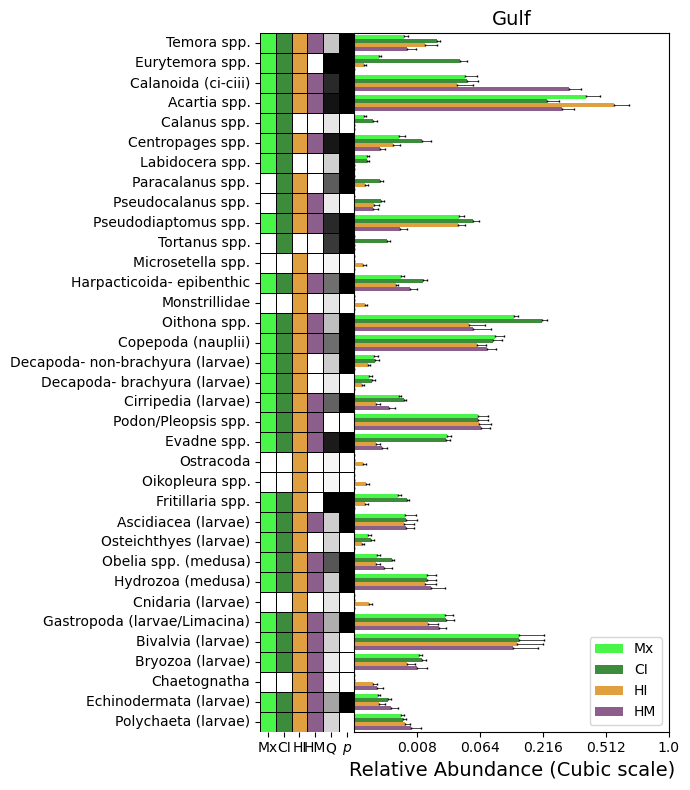

In [52]:
# function for creating Gulf taxa bar plots with both max and 5000, showing which taxa had differences between sorting processes across the ten samples
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap

for r, regionYear in enumerate(regionYears):
    if regionYear != 'Gulf':
        continue
    # Data for the plot
    type_colors = ['#3c8c3c', '#e0a03f', '#8c5e8c', '#49f549']
    
    # Simulated data (assuming `mean_richness_dict` exists in your context)
    keys = relabund_df['type'].unique()
    print('keys: ', keys)
    region_df = relabund_df[relabund_df['regionYear'] == regionYear].groupby(['newName', 'type']).agg({'Q': 'mean', 'mean relabund': 'mean', 'se': 'mean', 'p_bool': 'mean'}).reset_index()
    region_df = region_df.sort_values(['Q', 'newName'], ascending=[False, False]).reset_index(drop=True)

    region_df['newName'] = pd.Categorical(region_df['newName'], categories=order_from_r, ordered=True)
    #Sort the DataFrame by 'Taxa' column
    region_df = region_df.sort_values('newName')
    # print(region_df)

    #comment this out if not Gulf
    list0 = list(region_df[region_df['type'] == keys[3]]['mean relabund'])
    list1 = list(region_df[region_df['type'] == keys[0]]['mean relabund'])
    print("list0 and list1: ", list0, list1)
    list2 = list(region_df[region_df['type'] == keys[1]]['mean relabund'])
    list3 = list(region_df[region_df['type'] == keys[2]]['mean relabund'])
    print(list1)
    def cubic_transform(list1):
        arr1 = np.array(list1)
        cubed = np.cbrt(arr1)
        return list(cubed)

    transformed_list0 = cubic_transform(list0)
    transformed_list1 = cubic_transform(list1)
    transformed_list2 = cubic_transform(list2)
    transformed_list3 = cubic_transform(list3)
    print("second list1: ", list1)
    newNames = list(region_df[region_df['type'] == keys[0]]['newName'])
    print(newNames)
    print('list lengths: ', len(list0), len(list1), len(list2), len(list3))
    # Number of categories (groups of bars)
    n = len(list1)
    
    
    # X-axis positions for the bars (grouped in threes)
    ind = np.arange(n)
    
    # Width of each bar
    width = 0.2
    figheight = 8
    if r == 1:
        figheight = 12
    # Create figure with subplots for bars and heatmap
    fig, (ax_heatmap_0, ax_heatmap_1, ax_heatmap_2, ax_heatmap_3, ax_frieds, ax_ps, ax) = plt.subplots(1, 7, figsize=(7, figheight), gridspec_kw={'width_ratios': [1, 1, 1, 1, 1, 1, 20]})
    # Create bars for each list on the first axis (ax)

    ax.barh(ind - 1.5*width, transformed_list0, width, label=keys[3], color=type_colors[3])
    asymmetric_errors = np.array([np.zeros_like(region_df[region_df['type'] == keys[3]]['se'].to_numpy()), region_df[region_df['type'] == keys[3]]['se'].to_numpy()])
    total_cubed_errors = np.cbrt(np.array(list0) + asymmetric_errors[1])
    cubed_diffs = total_cubed_errors - np.array(transformed_list0)
    asymmetric_errors[1] = cubed_diffs
    ax.errorbar(transformed_list0, ind - 1.5*width * 1.15, xerr=asymmetric_errors, capsize=1, ecolor='black', 
            elinewidth=.5, linestyle='none')
    
    ax.barh(ind - .5*width, transformed_list1, width, label=keys[0], color=type_colors[0])
    asymmetric_errors = np.array([np.zeros_like(region_df[region_df['type'] == keys[0]]['se'].to_numpy()), region_df[region_df['type'] == keys[0]]['se'].to_numpy()])
    total_cubed_errors = np.cbrt(np.array(list1) + asymmetric_errors[1])
    cubed_diffs = total_cubed_errors - np.array(transformed_list1)
    asymmetric_errors[1] = cubed_diffs
    ax.errorbar(transformed_list1, ind - .5*width * 1.15, xerr=asymmetric_errors, capsize=1, ecolor='black', 
            elinewidth=.5, linestyle='none')
    
    ax.barh(ind +.5*width, transformed_list2, width, label=keys[1], color=type_colors[1])
    asymmetric_errors = np.array([np.zeros_like(region_df[region_df['type'] == keys[1]]['se'].to_numpy()), region_df[region_df['type'] == keys[1]]['se'].to_numpy()])
    total_cubed_errors = np.cbrt(np.array(list2) + asymmetric_errors[1])
    cubed_diffs = total_cubed_errors - np.array(transformed_list2)
    asymmetric_errors[1] = cubed_diffs
    ax.errorbar(transformed_list2, ind+.5*width, xerr=asymmetric_errors, capsize=1, ecolor='black', 
            elinewidth=.5, linestyle='none')
    
    ax.barh(ind + 1.5*width, transformed_list3, width, label=keys[2], color=type_colors[2])
    asymmetric_errors = np.array([np.zeros_like(region_df[region_df['type'] == keys[2]]['se'].to_numpy()), region_df[region_df['type'] == keys[2]]['se'].to_numpy()])
    total_cubed_errors = np.cbrt(np.array(list3) + asymmetric_errors[1])
    cubed_diffs = total_cubed_errors - np.array(transformed_list3)
    asymmetric_errors[1] = cubed_diffs
    ax.errorbar(transformed_list3, ind + 1.5*width * 1, xerr=asymmetric_errors, capsize=1, ecolor='black', 
            elinewidth=.5, linestyle='none')
    # Labeling the graph
    # ax.set_xlabel('Relative Abundance (' + r'$\sqrt[3]{scale}$' +')', fontsize=14)
    ax.set_xlabel('Relative Abundance (Cubic scale)', fontsize=14)
    ax.set_ylabel('')
    ax.set_title(regionYear, fontsize=14)
    ax.set_yticks(ind)
    xtick_locations = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax.set_xticks(xtick_locations, np.round(xtick_locations**3, 3))
    ax.set_yticklabels(['' for newName in newNames])
    ax.set_ylim(ind[-1] + width*2.5, ind[0] - width*2.5)
    # Adding a legend
    # ax.set_xlim([0, 0.01])
    ax.legend()
    ticks = ax.get_xticks()  # Get the current xticks
    ax.set_xticks(ticks[1:])  # Set xticks to exclude the first one
    ax.set_yticks([])
    
    # Create heatmap on the second axis (ax_heatmap)
    # Here, we're just using the 'transformed_list1', 'transformed_list2', and 'transformed_list3' values as heatmap intensity data.
    # You can adjust this to reflect any data you wish.
    colors1 = ['white', type_colors[0]]
    colors2 = ['white', type_colors[1]]
    colors3 = ['white', type_colors[2]]
    colors0 = ['white', type_colors[3]]
    colors4 = ['white', 'black']
    cmap0 = ListedColormap(colors0)
    cmap1 = ListedColormap(colors1)
    cmap2 = ListedColormap(colors2)
    cmap3 = ListedColormap(colors3)
    cmap4 = ListedColormap(colors4)
    heatmap_data = np.array([[1 if x > 0 else 0 for x in transformed_list0], [1 if x > 0 else 0 for x in transformed_list1], [1 if x > 0 else 0 for x in transformed_list2], [1 if x > 0 else 0 for x in transformed_list3]])
    
    print(np.shape(heatmap_data[0].reshape(-1, 1)))
    print(keys[0])
    print(heatmap_data[1])
    # Plot the heatmap using seaborn or imshow
    taxa_name_cols = []
    # for newName in newNames:
    #     taxa_name_cols.append(taxa_color_dict[newName])
    
    ax_heatmap_0 = sns.heatmap(heatmap_data[0].reshape(-1, 1), cmap=cmap0, cbar=False, ax=ax_heatmap_0, xticklabels=[keys[3]], yticklabels=['' + newName for newName in newNames], fmt=".2f", linewidths=0.5, linecolor='black')

    for tick, color in zip(ax_heatmap_1.get_yticklabels(), taxa_name_cols):
        tick.set_backgroundcolor(color)

    ax_heatmap_1 = sns.heatmap(heatmap_data[1].reshape(-1, 1), cmap=cmap1, cbar=False, ax=ax_heatmap_1, xticklabels=[keys[0]], yticklabels=['' for x in newNames], fmt=".2f", vmin=0, vmax=1, linewidths=0.5, linecolor='black')
    ax_heatmap_2 = sns.heatmap(heatmap_data[2].reshape(-1, 1), cmap=cmap2, cbar=False, ax=ax_heatmap_2, xticklabels=[keys[1]], yticklabels=['' for x in newNames], fmt=".2f", vmin=0, vmax=1, linewidths=0.5, linecolor='black')
    ax_heatmap_3 = sns.heatmap(heatmap_data[3].reshape(-1, 1), cmap=cmap3, cbar=False, ax=ax_heatmap_3, xticklabels=[keys[2]], yticklabels=['' for x in newNames], fmt=".2f",linewidths=0.5, linecolor='black')

    ax_ps = sns.heatmap(region_df[region_df['type'] == keys[0]]['p_bool'].to_numpy().reshape(-1, 1), cmap=cmap4, cbar=False, ax=ax_ps, xticklabels=['p'], yticklabels=['' for x in newNames], fmt=".2f",linewidths=0.5, linecolor='black')
    ax_frieds = sns.heatmap(region_df[region_df['type'] == keys[0]]['Q'].to_numpy().reshape(-1, 1), cmap='Greys', cbar=False, ax=ax_frieds, xticklabels=['Q'], yticklabels=['' for x in newNames], fmt=".2f",linewidths=0.5, linecolor='black')
    ax_heatmap_1.set_yticks([])
    ax_heatmap_2.set_yticks([])
    ax_heatmap_3.set_yticks([])  
    ax_ps.set_yticks([])
    ax_frieds.set_yticks([])
    labels = ax_ps.get_xticklabels()
    for label in labels:
        label.set_style('italic')
    # Adjust the layout to make it tight
    plt.tight_layout()
    plt.subplots_adjust(wspace=0)
    # Show the plot
    plt.show()


In [37]:
df = relabund_df[relabund_df['newName'] == 'Paracalanus spp.'].reset_index(drop=True)
df = df[df['regionYear'] == 'Gulf']
df

,Unnamed: 0,newName,FlowCamID,regionYear,type,abund,sumabund,relabund,Q,p_bool,mean relabund,se
0,3540,Paracalanus spp.,AMMP_Gulf_StPeters_1_20200903HT_250UM,Gulf,CI,1.000000,3847.000000,0.000260,14.0,1.0,0.000548,0.000184
1,3543,Paracalanus spp.,AMMP_Gulf_StPeters_1_20200903LT_250UM,Gulf,CI,5.000000,3268.000000,0.001530,14.0,1.0,0.000548,0.000184
2,3546,Paracalanus spp.,AMMP_Gulf_StPeters_1_20200904HT_250UM,Gulf,CI,1.000000,7495.000000,0.000133,14.0,1.0,0.000548,0.000184
3,3549,Paracalanus spp.,AMMP_Gulf_StPeters_2B_20200903_250UM,Gulf,CI,1.000000,2895.000000,0.000345,14.0,1.0,0.000548,0.000184
4,3552,Paracalanus spp.,AMMP_Gulf_StPeters_2_20200903HT_250UM,Gulf,CI,0.000000,4104.000000,0.000000,14.0,1.0,0.000548,0.000184
5,3555,Paracalanus spp.,AMMP_Gulf_StPeters_2_20200904HT_250UM,Gulf,CI,7.000000,4177.000000,0.001676,14.0,1.0,0.000548,0.000184
6,3558,Paracalanus spp.,AMMP_Gulf_StPeters_3B_20200903_250UM,Gulf,CI,1.000000,3322.000000,0.000301,14.0,1.0,0.000548,0.000184
7,3561,Paracalanus spp.,AMMP_Gulf_StPeters_3_20200903HT_250UM,Gulf,CI,1.000000,3231.000000,0.000310,14.0,1.0,0.000548,0.000184
8,3564,Paracalanus spp.,AMMP_Gulf_StPeters_3_20200903LT_250UM,Gulf,CI,1.000000,3594.000000,0.000278,14.0,1.0,0.000548,0.000184
9,3567,Paracalanus spp.,AMMP_Gulf_StPeters_3_20200904HT_250UM,Gulf,CI,2.000000,3077.000000,0.000650,14.0,1.0,0.000548,0.000184


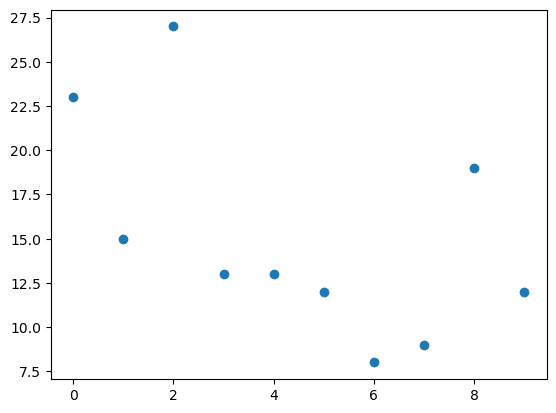

In [27]:
gulf_flow_counts = [23, 15, 27, 13, 13, 12, 8, 9, 19, 12]
plt.scatter(range(len(gulf_flow_counts)), gulf_flow_counts)
plt.show()

In [57]:
euph_df = relabund_df[relabund_df['newName'].str.contains('Euphau', na=False)]
euph_df = euph_df[euph_df['abund'] > 0]
euph_df

,Unnamed: 0,newName,FlowCamID,regionYear,type,abund,sumabund,relabund,Q,p_bool,mean relabund,se
1862,1896,Euphausiacea (larvae),AMMP_NL_S01_41_20200916AM_250UM,NL 2020,CI,1.0,7330.0,0.000136,4.0,0.0,0.000030,0.000020
1863,1899,Euphausiacea (larvae),AMMP_NL_S01_41_20200916PM_250UM,NL 2020,CI,1.0,6289.0,0.000159,4.0,0.0,0.000030,0.000020
1890,1860,Euphausiacea (larvae),21_10_05_NL_S1_Z17_0752_250,NL 2021,CI,1.0,788.0,0.001269,8.0,1.0,0.000597,0.000262
1893,1869,Euphausiacea (larvae),21_10_05_NL_S1_Z41_1327_250,NL 2021,CI,1.0,786.0,0.001272,8.0,1.0,0.000597,0.000262
1895,1875,Euphausiacea (larvae),21_10_06_NL_S1_Z17_1442_250,NL 2021,CI,2.0,877.0,0.002281,8.0,1.0,0.000597,0.000262
1896,1878,Euphausiacea (larvae),21_10_06_NL_S1_Z41_0839_250,NL 2021,CI,1.0,868.0,0.001152,8.0,1.0,0.000597,0.000262
1920,1950,Euphausiacea (nauplii),AMMP_NL_S01_33_20200916AM_250UM,NL 2020,CI,16.0,3447.0,0.004642,20.0,1.0,0.004994,0.000591
1921,1953,Euphausiacea (nauplii),AMMP_NL_S01_33_20200916PM_250UM,NL 2020,CI,14.0,5627.0,0.002488,20.0,1.0,0.004994,0.000591
1922,1956,Euphausiacea (nauplii),AMMP_NL_S01_41_20200916AM_250UM,NL 2020,CI,46.0,7330.0,0.006276,20.0,1.0,0.004994,0.000591
1923,1959,Euphausiacea (nauplii),AMMP_NL_S01_41_20200916PM_250UM,NL 2020,CI,32.0,6289.0,0.005088,20.0,1.0,0.004994,0.000591


In [60]:
arr = [0, 0, 0, 0, 0, 0, 0]
se = np.std(arr, ddof=1)/np.sqrt(len(arr))
std = np.std(arr, ddof=1)
print(std)
sqrt = np.sqrt(len(arr))
print(sqrt)
print(std/sqrt)
print(np.mean(arr))
print(se)

0.0
2.6457513110645907
0.0
0.0
0.0


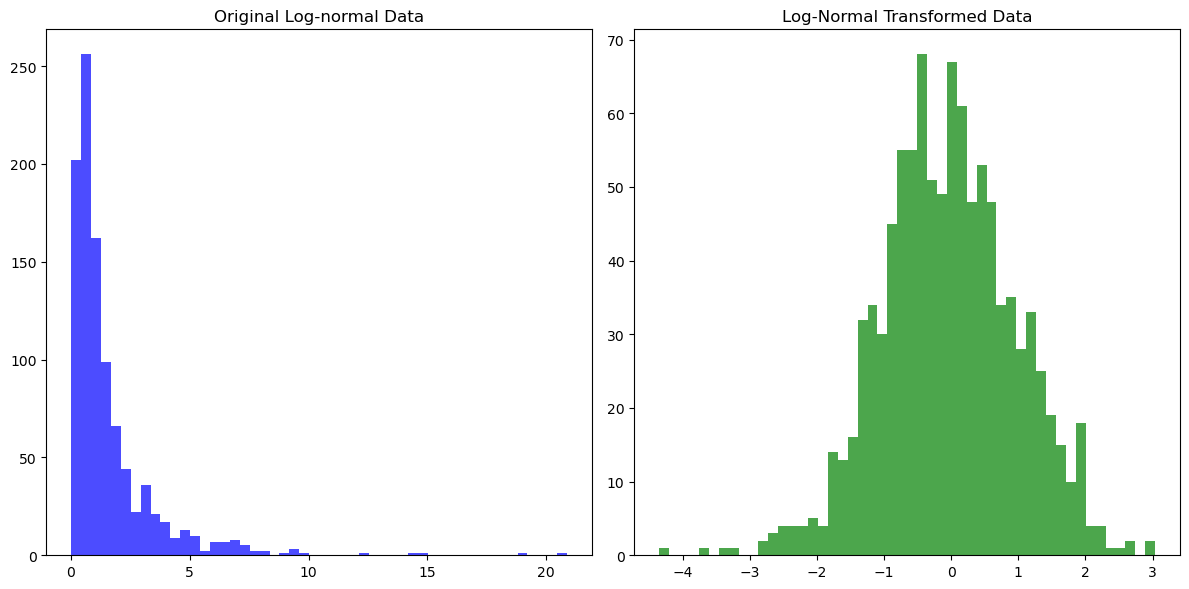

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Example data that is log-normal
data = np.random.lognormal(mean=0, sigma=1, size=1000)

# Apply the log-normal transformation (take the natural log of the data)
log_transformed_data = np.log(data)

# Plot the original data and the transformed data
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(data, bins=50, color='blue', alpha=0.7)
plt.title('Original Log-normal Data')

plt.subplot(1, 2, 2)
plt.hist(log_transformed_data, bins=50, color='green', alpha=0.7)
plt.title('Log-Normal Transformed Data')

plt.tight_layout()
plt.show()
